## Table of Content

1. [Import Libraries and create MYSQL connection](#section101)<br>
2. [Data Extraction and Exploration](#section2)<br>
    - 2.1 [Missing Data Imputation](#section201)<br>
         - 2.1.1 [Missing State](#section202)<br>
         - 2.1.2 [Missing Longitude and Latitude](#section203)<br>
         - 2.1.3 [Missing Device_ID](#section204)<br>
    - 2.2 [Anamoly Detection](#section205)<br>
    - 2.3 [Merging Datasets - Phone, Gender and Events](#section206)<br>
3. [Anamoly Detection](#section3)<br>
4. [Plotting of Distributions](#section4)<br>
    - 4.1 [Distribution of Users(device_id) across States](#section400)<br>
    - 4.2 [Distribution of Users across Phone Brands(10 Most used Phone Brands)](#section401)<br>
    - 4.3 [Distribution of Users across Gender](#section402)<br>
    - 4.4 [Distribution of Users across Age Segments](#section403)<br>
    - 4.5 [Distribution of Phone Brands(10 Most used Phone Brand): Age Segment, State, Gender](#section404)<br>
    - 4.6 [Distribution of Gender for each State, Age Segment and Phone Brand(10 Most used Phone Brands)](#section405)<br>
    - 4.7 [Distribution of Age Segments for each State, Gender and Phone Brand(10 Most used Phone Brands)](#section406)<br>
    - 4.8 [Hourly distribution of Phone Calls](#section407)<br>
    - 4.9 [Users on the Map using any suitable package](#section408)<br>
5. [Conclusion](#section5)
6. [CoreTeam](#sectioc6)

<a id=section101></a>
### 1. Import Libraries and Create MySQL Connection

In [1]:
#!pip install mysql-connector

In [2]:
import mysql.connector
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
from collections import Counter

import pandas_profiling
import matplotlib.pyplot as plt  
import seaborn as sns            
%matplotlib inline
sns.set()

#### Connection with the Database

In [3]:
# connection details
myDB = mysql.connector.connect(
   host="cpanel.insaid.co",
   user="student",
   passwd="student",
   database='Capstone1'
)

<a id=section2></a>
### 2. Data Extraction and Exploration

In [4]:
# open cursor
cursor = myDB.cursor()
# query
query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE table_schema ='Capstone1'"
# execute query
cursor.execute(query)
# fetch results
result = cursor.fetchall()
# print results
for table in result:
    print (table)

# close connection
#cnx.close()

('events_data',)
('gender_age_train',)
('phone_brand_device_model',)


In [5]:
cursor = myDB.cursor()

#### Queries

In [6]:
query_gender_age_train = ("SELECT * FROM gender_age_train")
query_phone_brand_device_model = ("SELECT * FROM phone_brand_device_model")
#query_events_data = ("select * from events_data where state in ('TamilNadu', 'Manipur', 'Chandigarh', 'Tripura', 'UttarPradesh', 'ArunachalPradesh')")

In [7]:
cursor.execute(query_gender_age_train)
table_rows = cursor.fetchall()
df_gender_age_train = pd.DataFrame(table_rows,columns = ['device_id','gender','age','group'])

In [8]:
cursor.execute(query_phone_brand_device_model)
table_rows = cursor.fetchall()
df_phone_brand_device_model = pd.DataFrame(table_rows, columns=['device_id', 'phone_brand', 'device_model'])

In [9]:
'''
def Read_GDrive_csv():
  #install PyDrive - Commnet If already Installed
  !pip install -U -q PyDrive

  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  link = 'https://drive.google.com/open?id=1WMRSPomIeyrVkaEhxYaoeTgcLezVZCjC'
  fluff, id = link.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('events_data.csv')
'''

"\ndef Read_GDrive_csv():\n  #install PyDrive - Commnet If already Installed\n  !pip install -U -q PyDrive\n\n  from pydrive.auth import GoogleAuth\n  from pydrive.drive import GoogleDrive\n  from google.colab import auth\n  from oauth2client.client import GoogleCredentials\n\n  auth.authenticate_user()\n  gauth = GoogleAuth()\n  gauth.credentials = GoogleCredentials.get_application_default()\n  drive = GoogleDrive(gauth)\n\n  link = 'https://drive.google.com/open?id=1WMRSPomIeyrVkaEhxYaoeTgcLezVZCjC'\n  fluff, id = link.split('=')\n  downloaded = drive.CreateFile({'id':id}) \n  downloaded.GetContentFile('events_data.csv')\n"

In [10]:
'''
import sys
IN_COLAB = 'google.colab' in sys.modules
if(IN_COLAB):
  Read_GDrive_csv()

df_all_events_data = pd.read_csv('events_data.csv')
'''

"\nimport sys\nIN_COLAB = 'google.colab' in sys.modules\nif(IN_COLAB):\n  Read_GDrive_csv()\n\ndf_all_events_data = pd.read_csv('events_data.csv')\n"

In [11]:
df_all_events_data = pd.read_csv("C://Users//vbhak//OneDrive//events_data.csv")

In [12]:
df_gender_age_train = pd.read_sql("SELECT * FROM gender_age_train", myDB)
df_phone_brand_device_model = pd.read_sql("SELECT * FROM phone_brand_device_model", myDB)
myDB.close()



In [13]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [14]:
missing_data(df_gender_age_train)

Total  Percent
device_id      0      0.0
gender         0      0.0
age            0      0.0
group          0      0.0

In [15]:
missing_data(df_phone_brand_device_model)

Total  Percent
device_id         0      0.0
phone_brand       0      0.0
device_model      0      0.0

In [16]:
missing_data(df_all_events_data)

Total   Percent
device_id    453  0.013926
longitude    423  0.013004
latitude     423  0.013004
state        377  0.011589
event_id       0  0.000000
timestamp      0  0.000000
city           0  0.000000

####  Data Analysis - Gender Age data

In [17]:
df_gender_age_train.shape

(74645, 4)

In [18]:
df_gender_age_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74645 entries, 0 to 74644
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   device_id  74645 non-null  int64 
 1   gender     74645 non-null  object
 2   age        74645 non-null  int64 
 3   group      74645 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [19]:
df_gender_age_train.describe()

device_id           age
count  7.464500e+04  74645.000000
mean  -7.491354e+14     31.410342
std    5.327150e+18      9.868735
min   -9.223067e+18      1.000000
25%   -4.617367e+18     25.000000
50%   -1.841362e+16     29.000000
75%    4.636656e+18     36.000000
max    9.222849e+18     96.000000

In [20]:
df_phone_brand_device_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87726 entries, 0 to 87725
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   device_id     87726 non-null  int64 
 1   phone_brand   87726 non-null  object
 2   device_model  87726 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [21]:
df_gender_age_train.describe(include='all')

device_id gender           age   group
count   7.464500e+04  74645  74645.000000   74645
unique           NaN      2           NaN      12
top              NaN      M           NaN  M23-26
freq             NaN  47904           NaN    9605
mean   -7.491354e+14    NaN     31.410342     NaN
std     5.327150e+18    NaN      9.868735     NaN
min    -9.223067e+18    NaN      1.000000     NaN
25%    -4.617367e+18    NaN     25.000000     NaN
50%    -1.841362e+16    NaN     29.000000     NaN
75%     4.636656e+18    NaN     36.000000     NaN
max     9.222849e+18    NaN     96.000000     NaN

**Observations** No Null Values in Gender Age Data

In [22]:
df_gender_age_train.head()

device_id gender  age   group
0 -8076087639492063270      M   35  M32-38
1 -2897161552818060146      M   35  M32-38
2 -8260683887967679142      M   35  M32-38
3 -4938849341048082022      M   30  M29-31
4   245133531816851882      M   30  M29-31

In [23]:
df_gender_age_train['gender'].value_counts()

M    47904
F    26741
Name: gender, dtype: int64

Text(0, 0.5, 'Age Groups')

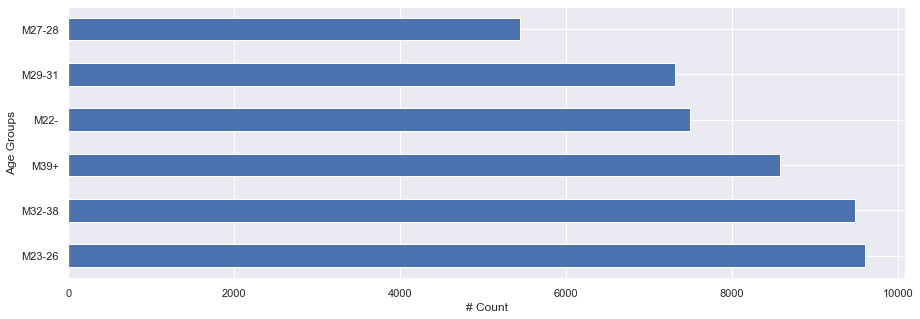

In [24]:
# Male users age group wise to see which group has maximum mobile usage
plt.figure(figsize=(15,5))
df_gender_age_train[df_gender_age_train['gender']=='M']['group'].value_counts().plot.barh()
plt.xlabel("# Count")
plt.ylabel("Age Groups")

Text(0, 0.5, 'Age Groups')

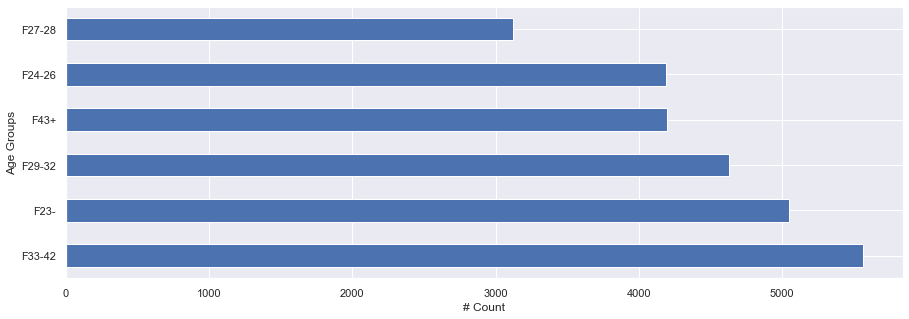

In [25]:
# Female users age group wise to see which group has maximum mobile usage
plt.figure(figsize=(15,5))
df_gender_age_train[df_gender_age_train['gender']=='F']['group'].value_counts().plot.barh()
plt.xlabel("# Count")
plt.ylabel("Age Groups")

Text(0.5, 0, 'Age')

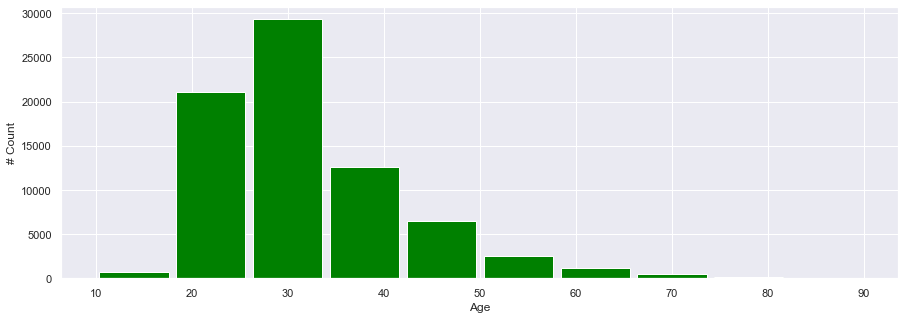

In [26]:
plt.figure(figsize=(15,5))
range = (10,90)
plt.hist(df_gender_age_train['age'], 10, range, color = 'green', histtype = 'bar', rwidth = 0.9)
plt.ylabel("# Count")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

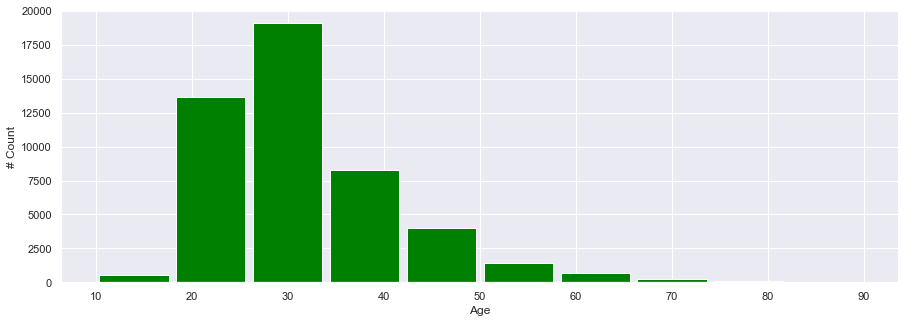

In [27]:
plt.figure(figsize=(15,5))
range = (10,90)
plt.hist(df_gender_age_train[df_gender_age_train['gender']=='M']['age'], 10, range, color = 'green', histtype = 'bar', rwidth = 0.9)
plt.ylabel("# Count")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

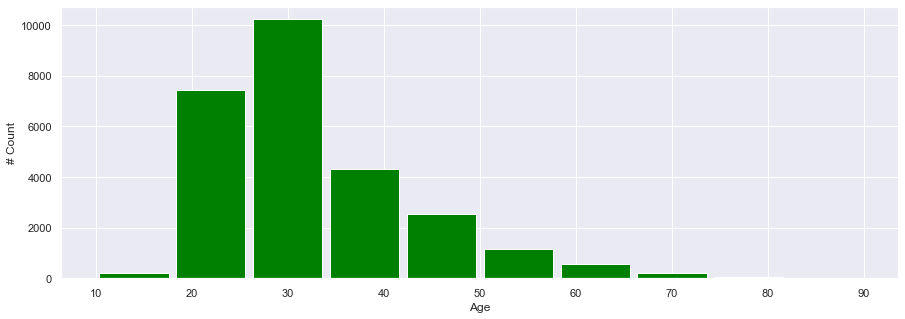

In [28]:
plt.figure(figsize=(15,5))
range = (10,90)
plt.hist(df_gender_age_train[df_gender_age_train['gender']=='F']['age'], 10, range, color = 'green', histtype = 'bar', rwidth = 0.9)
plt.ylabel("# Count")
plt.xlabel("Age")

In [29]:
# profile = pandas_profiling.ProfileReport(df_phone_brand_device_model)
# profile.to_file(output_file="phone_brand_device_model_data_before_preprocessing.html")

In [30]:
# profile = pandas_profiling.ProfileReport(df_gender_age_train)
# profile.to_file(output_file="gender_age_train_data_before_preprocessing.html")

**Observations** 
1. People of age group 20 to 40 are using mobiles more as compared to other age groups.
2. Mojority of people stops using mobile after the age of 60.
3. Males are using mobile more than females.
4. People start using mobile after the age of 10.  

Person whose age is 1 is also using mobile so it is outlier

#### Data Analysis - Phone Brand Data

In [31]:
df_phone_brand_device_model.shape

(87726, 3)

In [32]:
df_phone_brand_device_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87726 entries, 0 to 87725
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   device_id     87726 non-null  int64 
 1   phone_brand   87726 non-null  object
 2   device_model  87726 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [33]:
df_phone_brand_device_model.describe()

device_id
count  8.772600e+04
mean  -5.212557e+15
std    5.330157e+18
min   -9.223322e+18
25%   -4.623331e+18
50%   -3.109802e+16
75%    4.635194e+18
max    9.222849e+18

In [34]:
df_phone_brand_device_model.describe(include='all')

device_id phone_brand device_model
count   8.772600e+04       87726        87726
unique           NaN         116         1467
top              NaN          小米       红米note
freq             NaN       21645         3500
mean   -5.212557e+15         NaN          NaN
std     5.330157e+18         NaN          NaN
min    -9.223322e+18         NaN          NaN
25%    -4.623331e+18         NaN          NaN
50%    -3.109802e+16         NaN          NaN
75%     4.635194e+18         NaN          NaN
max     9.222849e+18         NaN          NaN

**Observations** No Null Values in Phone Brand Device Data

In [35]:
df_phone_brand_device_model.head()

device_id phone_brand device_model
0  1877775838486905855        vivo          Y13
1 -3766087376657242966          小米         V183
2 -6238937574958215831        OPPO          R7s
3  8973197758510677470          三星        A368t
4 -2015528097870762664          小米      红米Note2

**Observations** There are Chineese names for phone_brand & device_model which needs treatment

In [36]:
brands_in_chinese = ['华为','小米','三星','魅族','酷派','乐视','联想 ','vivo','OPPO','HTC','LG','TCL','LOGO','Lovme','ZUK','PPTV','努比亚','海信','天语','夏新','欧比', '优米', '欧博信', '奇酷', '锤子', '酷比魔方', '语信', '朵唯', '德赛', '一加',
       '华硕', '普耐尔', '易派', '摩托罗拉', '优购', '酷珀', '梦米', '爱派尔', '昂达', '邦华',
       '聆韵', '中国移动', '诺亚信', '酷比', '艾优尼', '斐讯', '富可视', '欧新', '美图', '宝捷讯',
       '青橙', '果米', '波导', '诺基亚', '神舟', '糯米', '亿通', '纽曼', '唯米', '百立丰',
       '沃普丰', '虾米', '凯利通', '贝尔丰', '至尊宝', '蓝魔', '青葱', '白米', '大可乐', '尼比鲁',
       '康佳', '乡米', '黑米', '海尔', '优语', '维图', '米歌', '广信', 'E派', '小杨树', '糖葫芦',
       '西米', '谷歌', '长虹', '飞利浦', '惠普', '台电', '大Q', '鲜米', '先锋', '欧奇']
brands_in_english = ['Huawei','Xiaomi','Samsung','Meizu','Coolpad','LeEco','Lenovo','vivo','OPPO','HTC','LG','TCL','LOGO','Lovme','ZUK','PPTV','Nubia','Hisense','Amagatarai','Amoi','Obi', 'Youmi', 'Obson', 'Qiku', 'Hammer', 'Cubei Cube', 'Letters', 'Duowei', 'Desai', 'One Plus','ASUS', 'Punale', 'Yipai', 'Motorola', 'Yougo', 'Cooper', 'Mengmi', 'Aipair', 'Onda', 'Banghua', 'Lingyun', 'China Mobile', 'Noah',' Coolby ',' Aiyouni ',' Feixun ',' Focus', 'Ou Xin', 'Meitu', 'Projet News','Green Orange', 'Fruit Rice', 'Flyer', 'Nokia', 'Shenzhou', 'Glutinous Rice', 'Yi Tong', 'Newman', 'Wei Mi', 'Bai Li Feng','Wopfung', 'Shrimp', 'Kellystone', 'Bellfonte', 'Extreme Treasure', 'Blue Devils', 'Scallion', 'White Rice', 'Big Cola', 'Nibiru','Kangjia', 'Xianmi', 'Black Rice', 'Haier', 'Youyu', 'Weitu', 'Mi Ge', 'Guangxin', 'E-Pay', 'Little Poplar', ' Candied ','Simi', 'Google', 'Changhong', 'Philips', 'HP', 'Taipower', 'Big Q', 'Fresh Rice', 'Pioneer', 'Ouqi']

brands_dict1 = dict(zip(brands_in_chinese, brands_in_english)) 


In [37]:
def translator(val):
    if val in brands_dict1:
        return brands_dict1[val]
    else:
        return val

In [38]:
df_phone_brand_device_model.phone_brand = df_phone_brand_device_model.phone_brand.apply(translator)

In [39]:
df_phone_brand_device_model.head()

device_id phone_brand device_model
0  1877775838486905855        vivo          Y13
1 -3766087376657242966      Xiaomi         V183
2 -6238937574958215831        OPPO          R7s
3  8973197758510677470     Samsung        A368t
4 -2015528097870762664      Xiaomi      红米Note2

In [40]:
df_phone_brand_device_model['phone_brand'].value_counts().head(10)

Xiaomi     21645
Samsung    19211
Huawei     15181
vivo        7596
OPPO        6717
Meizu       5531
Coolpad     3979
HTC         1272
Lenovo       982
LeEco        841
Name: phone_brand, dtype: int64

Text(0.5, 0, 'Phone Brands')

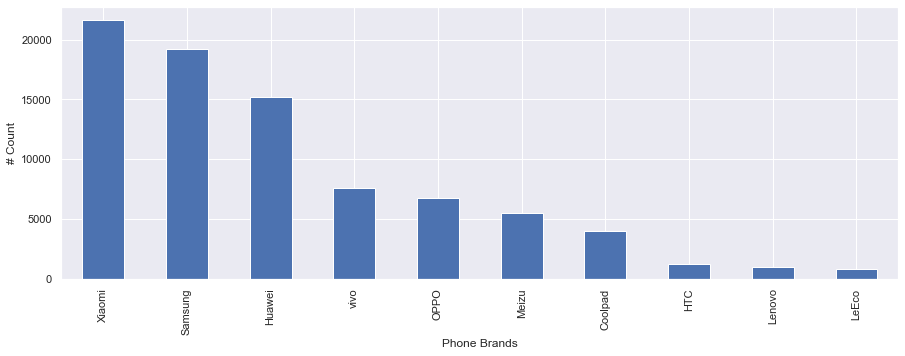

In [41]:
plt.figure(figsize=(15,5))
df_phone_brand_device_model['phone_brand'].value_counts().head(10).plot.bar()
plt.ylabel("# Count")
plt.xlabel("Phone Brands")

In [42]:
df_phone_brand_device_model['device_model'].value_counts().head(10)

红米note           3500
MI 3             2739
MI 2S            2547
Galaxy Note 3    2378
MI 4             2256
Galaxy S4        1910
Galaxy Note 2    1877
荣耀6              1471
荣耀畅玩4X           1279
荣耀3C             1206
Name: device_model, dtype: int64

In [43]:
df_phone_brand_device_model['device_model'].replace({'红米note': 'Redmi note', '荣耀6 plus': 'Redmi 1S', '天鉴W900S': 'Tianjian W900S','乐檬X3': 'Music lemon X3', '荣耀6': 'Glory 6', '荣耀畅玩4X': 'Honor Play 4X', '荣耀3C': 'Glory 3C', '荣耀6 Plus':'Honor 6 Plus' }, inplace=True)

Text(0.5, 0, 'Device Models')

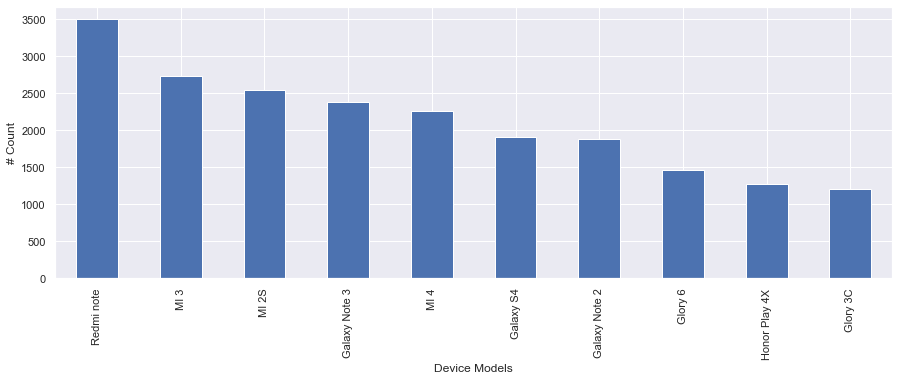

In [44]:
plt.figure(figsize=(15,5))
df_phone_brand_device_model['device_model'].value_counts().head(10).plot.bar()
plt.ylabel("# Count")
plt.xlabel("Device Models")

In [45]:
for i in df_phone_brand_device_model['phone_brand'].head(10).unique():
    print ('-----',i,'------')
    print (df_phone_brand_device_model[df_phone_brand_device_model['phone_brand']==i]['device_model'].value_counts().head())

----- vivo ------
X3T      425
X5Pro    401
X3L      333
Xplay    293
X5SL     279
Name: device_model, dtype: int64
----- Xiaomi ------
Redmi note    3500
MI 3          2739
MI 2S         2547
MI 4          2256
红米1S          1191
Name: device_model, dtype: int64
----- OPPO ------
R7         663
R7 Plus    459
R7s        423
Find 7     381
R3         335
Name: device_model, dtype: int64
----- Samsung ------
Galaxy Note 3    2378
Galaxy S4        1910
Galaxy Note 2    1877
Galaxy S3        1156
Galaxy S5         827
Name: device_model, dtype: int64


#### Data Analysis - Events Data

In [46]:
df_all_events_data.shape

(3252950, 7)

In [47]:
df_all_events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   event_id   int64  
 1   device_id  float64
 2   timestamp  object 
 3   longitude  float64
 4   latitude   float64
 5   city       object 
 6   state      object 
dtypes: float64(3), int64(1), object(3)
memory usage: 173.7+ MB


In [48]:
df_all_events_data.describe()

event_id     device_id     longitude      latitude
count  3.252950e+06  3.252497e+06  3.252527e+06  3.252527e+06
mean   1.626476e+06  1.012200e+17  7.815868e+01  2.168851e+01
std    9.390459e+05  5.316758e+18  4.235570e+00  5.789111e+00
min    1.000000e+00 -9.222957e+18  1.256700e+01  8.190110e+00
25%    8.132382e+05 -4.540611e+18  7.583543e+01  1.780171e+01
50%    1.626476e+06  1.726820e+17  7.726814e+01  2.216454e+01
75%    2.439713e+06  4.861813e+18  8.031916e+01  2.868278e+01
max    3.252950e+06  9.222849e+18  9.545946e+01  4.187190e+01

<a id=section201></a>
## 2.1 Missing data Imputation 

We have seen above that in events dataset - `state`, `longitude`, `latitude` and `device_id` have missing values, we will be imputing these

<a id=section202></a>
### 2.1.1 Missing State 

In [49]:
df_all_events_data[df_all_events_data['state'].isnull()]['city'].unique()

array(['Pune', 'Visakhapatnam', 'Indore', 'Chennai', 'Delhi',
       'Channapatna', 'Jaipur', 'Gangarampur', 'Arambagh'], dtype=object)

In [50]:
#Replacing null states only for `AndraPradesh`
df_all_events_data.loc[(df_all_events_data['city'] =='Visakhapatnam') \
    & (df_all_events_data['state'].isnull()),'state'] = 'AndhraPradesh'


In [51]:
l = ['AndhraPradesh', 'Pondicherry', 'Mizoram', 'Andaman and Nicobar Islands', 'Meghalaya', 'HimachalPradesh']
#list_of_states = ['WestBengal', 'Karnataka', 'Gujarat', 'Bihar', 'Punjab', 'Kerala']

In [52]:
df_all_events_data[df_all_events_data['device_id'].isnull()]['longitude'].unique()

array([75.882956, 75.888487, 75.846007, 75.923332, 75.992551, 73.862756,
       73.860165, 83.357991, 77.292481, 73.926499, 80.343613, 80.309272,
       77.274814, 83.371738, 75.95805 , 83.342711, 75.836167, 80.335435,
       73.169345, 70.686387, 77.303153])

In [53]:
chk1=df_all_events_data[df_all_events_data['device_id'].isnull()].value_counts(df_all_events_data['longitude'])
chk1

longitude
75.836167    27
75.846007    27
75.888487    27
73.860165    24
73.862756    24
73.926499    24
83.371738    23
83.357991    23
83.342711    23
77.274814    23
77.292481    23
77.303153    23
80.309272    21
80.343613    21
80.335435    21
75.958050    17
75.923332    17
75.882956    17
75.992551    16
73.169345    16
70.686387    16
dtype: int64

In [54]:
df_all_events_data[df_all_events_data['device_id'].isnull()]['latitude'].unique()

array([22.814519, 26.948689, 26.960796, 22.777781, 31.561747, 18.628057,
       18.566925, 17.805195, 28.719966, 18.614812, 13.153332, 13.149176,
       28.721053, 17.752819, 22.817526, 17.822906, 26.95399 , 13.189053,
       21.194283, 21.790693, 28.728888])

<a id=section204></a>
### 2.1.3 Missing Device_ID

In [55]:
chk2=df_all_events_data[df_all_events_data['device_id'].isnull()].value_counts(df_all_events_data['latitude'])
chk2

latitude
26.960796    27
26.953990    27
26.948689    27
18.628057    24
18.566925    24
18.614812    24
28.728888    23
28.721053    23
28.719966    23
17.822906    23
17.805195    23
17.752819    23
13.153332    21
13.189053    21
13.149176    21
22.777781    17
22.814519    17
22.817526    17
21.790693    16
21.194283    16
31.561747    16
dtype: int64

In [56]:
df_all_events_data['device_id']=df_all_events_data['device_id'].astype('Int64')

In [57]:
print(df_all_events_data[(df_all_events_data['latitude'] == 17.752819) & (df_all_events_data['longitude'] == 83.371738)]['device_id'].unique())

<IntegerArray>
[-3130903177076173312, <NA>]
Length: 2, dtype: Int64


In [58]:
print(df_all_events_data[(df_all_events_data['latitude'] == 17.805195) & (df_all_events_data['longitude'] ==83.357991 )]['device_id'].unique())

<IntegerArray>
[6844192269280790528, <NA>]
Length: 2, dtype: Int64


In [59]:
print(df_all_events_data[(df_all_events_data['latitude'] == 17.822906) & (df_all_events_data['longitude'] ==83.342711 )]['device_id'].unique())

<IntegerArray>
[6619714762103552000, <NA>]
Length: 2, dtype: Int64


In [60]:
df_all_events_data.loc[(df_all_events_data['state']=='AndhraPradesh') &(df_all_events_data['longitude']== 83.357991)\
                       &(df_all_events_data['latitude']==17.805195)\
                       &(df_all_events_data['device_id'].isnull()), 'device_id'] = 6844192269280790528

In [61]:
df_all_events_data.loc[(df_all_events_data['state']=='AndhraPradesh') &(df_all_events_data['longitude']== 83.371738)\
                       &(df_all_events_data['latitude']==17.752819)\
                       &(df_all_events_data['device_id'].isnull()), 'device_id'] = -3130903177076173312

In [62]:
df_all_events_data.loc[(df_all_events_data['state']=='AndhraPradesh') &(df_all_events_data['longitude']== 83.342711)\
                       &(df_all_events_data['latitude']==17.822906)\
                       &(df_all_events_data['device_id'].isnull()), 'device_id'] = 6619714762103552000

- # looks like all 3 device_id  mapped and can be filled in to missing values perfectly

In [63]:
df_all_events_data['device_id'].value_counts()

 5536513450525271040    33426
-4792366453774469120    14568
 442842061129641600      6731
-6242501228649113600     4150
-8340098378141155328     3973
                        ...  
-1851349715436622848        1
-658553895270674944         1
 8881886029341934592        1
-6750058069484553216        1
 5128677725965299712        1
Name: device_id, Length: 60865, dtype: Int64

In [64]:
df_all_events_data['device_id'].isnull().sum()

384

- all 69 values are filled out

In [65]:
#Taking only 6 states data
df_events_data = df_all_events_data.loc[df_all_events_data['state'].isin(l)]

In [66]:
df_events_data.shape

(327657, 7)

In [67]:
df_events_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327657 entries, 5 to 3252948
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   event_id   327657 non-null  int64  
 1   device_id  327657 non-null  Int64  
 2   timestamp  327657 non-null  object 
 3   longitude  327594 non-null  float64
 4   latitude   327594 non-null  float64
 5   city       327657 non-null  object 
 6   state      327657 non-null  object 
dtypes: Int64(1), float64(2), int64(1), object(3)
memory usage: 20.3+ MB


- **looks like we have to fill for longitude and latitude**

In [68]:
df_events_data.describe()

event_id     device_id      longitude       latitude
count  3.276570e+05  3.276570e+05  327594.000000  327594.000000
mean   1.625846e+06  9.454218e+16      82.419469      17.623937
std    9.403988e+05  5.343419e+18       2.105303       1.487593
min    5.985000e+03 -9.222173e+18      12.567400      10.941103
25%    8.112420e+05 -4.718484e+18      82.193543      17.744893
50%    1.627221e+06 -2.473337e+16      83.339508      17.775366
75%    2.439822e+06  4.865607e+18      83.372516      17.807568
max    3.252943e+06  9.220807e+18      92.827113      41.871900

In [69]:
df_events_data.describe(include='all')

event_id     device_id            timestamp      longitude  \
count   3.276570e+05  3.276570e+05               327657  327594.000000   
unique           NaN           NaN               239787            NaN   
top              NaN           NaN  2016-05-05 11:20:46            NaN   
freq             NaN           NaN                   12            NaN   
mean    1.625846e+06  9.454218e+16                  NaN      82.419469   
std     9.403988e+05  5.343419e+18                  NaN       2.105303   
min     5.985000e+03 -9.222173e+18                  NaN      12.567400   
25%     8.112420e+05 -4.718484e+18                  NaN      82.193543   
50%     1.627221e+06 -2.473337e+16                  NaN      83.339508   
75%     2.439822e+06  4.865607e+18                  NaN      83.372516   
max     3.252943e+06  9.220807e+18                  NaN      92.827113   

             latitude           city          state  
count   327594.000000         327657         327657  
unique            NaN            112              5  
top               NaN  Visakhapatnam  AndhraPradesh  
freq              NaN         235772         321379  
mean        17.623937            NaN            NaN  
std          1.487593            NaN            NaN  
min         10.941103            NaN            NaN  
25%         17.744893            NaN            NaN  
50%         17.775366            NaN            NaN  
75%         17.807568            NaN            NaN  
max         41.871900            NaN            NaN

<a id=section203></a>
### 2.1.2 Missing longitude and latitude

**Replace missing `longitude` and `latitude` with mode values**

In [70]:
df_events_data[df_events_data['longitude'].isnull()]['city'].unique()

array(['Visakhapatnam'], dtype=object)

In [71]:
df_events_data[df_events_data['longitude'].isnull()]['state'].unique()

array(['AndhraPradesh'], dtype=object)

In [72]:
pd.reset_option('^display.', silent=True)
c = ['state','city','longitude','latitude']
l = ['Visakhapatnam']
df_events_data[c][df_events_data['city'].isin(l)].groupby(df_events_data['city']).describe()

longitude                                                      \
                  count       mean       std      min        25%        50%   
city                                                                          
Visakhapatnam  235709.0  83.353957  0.277583  12.5674  83.332645  83.357319   

                                     latitude                                  \
                     75%        max     count       mean       std        min   
city                                                                            
Visakhapatnam  83.378166  83.399986  235709.0  17.785285  0.111152  17.740052   

                                                         
                     25%        50%        75%      max  
city                                                     
Visakhapatnam  17.761957  17.783645  17.807361  41.8719

In [73]:
Visakhapatnam_latitude_mode = df_events_data['latitude'][df_events_data['city'] == 'Visakhapatnam'].mode()
Visakhapatnam_latitude_mode

0    17.829748
dtype: float64

In [74]:
Visakhapatnam_longitude_mode = df_events_data['longitude'][df_events_data['city'] == 'Visakhapatnam'].mode()
Visakhapatnam_longitude_mode

0    83.326714
dtype: float64

In [75]:
df_events_data_copy = df_events_data

In [76]:
df_events_data_copy.shape

(327657, 7)

In [77]:
#Replacing missing longitude & latitude in `Araria`,`Bagaha` & `Moga`
pd.options.display.float_format = '{:30,.1f}'.format
df_events_data.loc[(df_events_data['city'] =='Visakhapatnam') \
                   & (df_events_data['longitude'].isnull()),'longitude']= '83.326714'


C:\Users\vbhak\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [78]:
pd.options.display.float_format = '{:30,.1f}'.format
df_events_data.loc[(df_events_data['city'] =='Visakhapatnam') \
                   & (df_events_data['latitude'].isnull()),'latitude']= '17.829748'


In [79]:
df_events_data.head()

event_id             device_id            timestamp  \
5    1078723   -512424213979236416  2016-05-02 02:21:20   
7     280014  -8879643774076165120  2016-05-05 13:06:01   
12   2334601   -601883305299256832  2016-05-05 11:17:48   
32   2064864  -2764520535330416640  2016-05-03 23:58:20   
48   1341801   4986891477794016256  2016-05-07 15:24:58   

                        longitude                       latitude  \
5                            83.4                           17.8   
7                            78.2                           16.4   
12                           83.4                           17.8   
32                           83.3                           17.8   
48                           83.3                           17.8   

             city          state  
5   Visakhapatnam  AndhraPradesh  
7        Wanparti  AndhraPradesh  
12  Visakhapatnam  AndhraPradesh  
32  Visakhapatnam  AndhraPradesh  
48  Visakhapatnam  AndhraPradesh

In [85]:
missing_data(df_events_data)

Total                        Percent
event_id       0                            0.0
device_id      0                            0.0
timestamp      0                            0.0
longitude      0                            0.0
latitude       0                            0.0
city           0                            0.0
state          0                            0.0

In [86]:
df_events_data.info(verbose = True, memory_usage = 'deep', show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327657 entries, 5 to 3252948
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event_id   327657 non-null  int64 
 1   device_id  327657 non-null  Int64 
 2   timestamp  327657 non-null  object
 3   longitude  327657 non-null  object
 4   latitude   327657 non-null  object
 5   city       327657 non-null  object
 6   state      327657 non-null  object
dtypes: Int64(1), int64(1), object(5)
memory usage: 103.0 MB


<a id=section205></a>
### 2.2 Anomaly Detection [Outliers] 

In [87]:
df_events_data.loc[:,'longitude':'latitude']=df_events_data.loc[:,'longitude':'latitude'].astype(float)

C:\Users\vbhak\anaconda3\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [88]:
df_events_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327657 entries, 5 to 3252948
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   event_id   327657 non-null  int64  
 1   device_id  327657 non-null  Int64  
 2   timestamp  327657 non-null  object 
 3   longitude  327657 non-null  float64
 4   latitude   327657 non-null  float64
 5   city       327657 non-null  object 
 6   state      327657 non-null  object 
dtypes: Int64(1), float64(2), int64(1), object(3)
memory usage: 28.4+ MB


Text(0.5, 0, 'Longitude')

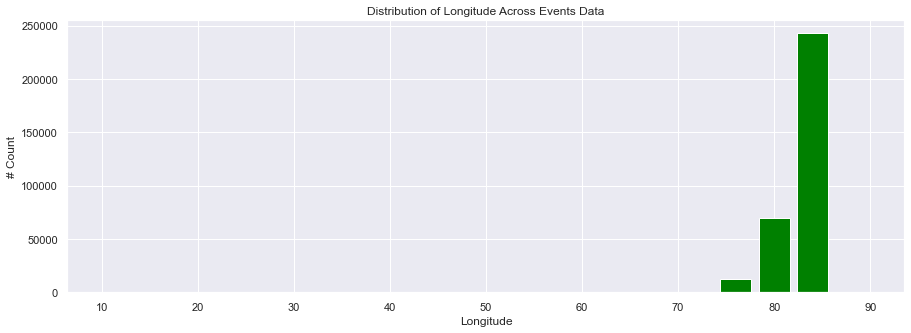

In [89]:
plt.figure(figsize=(15,5))
plt.hist(df_events_data['longitude'], 20, range, color = 'green', histtype = 'bar', rwidth = 0.8)
plt.title('Distribution of Longitude Across Events Data');
plt.ylabel("# Count")
plt.xlabel("Longitude")

Text(0.5, 0, 'Latitude')

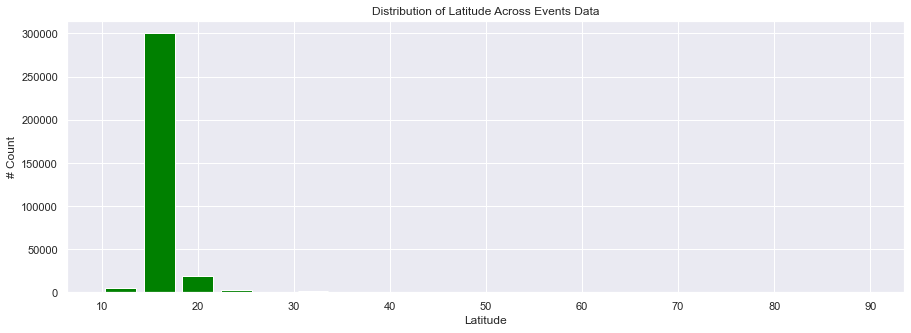

In [90]:
plt.figure(figsize=(15,5))
plt.hist(df_events_data['latitude'], 20, range, color = 'green', histtype = 'bar', rwidth = 0.8)
plt.title('Distribution of Latitude Across Events Data');
plt.ylabel("# Count")
plt.xlabel("Latitude")

Text(0, 0.5, '# Value')

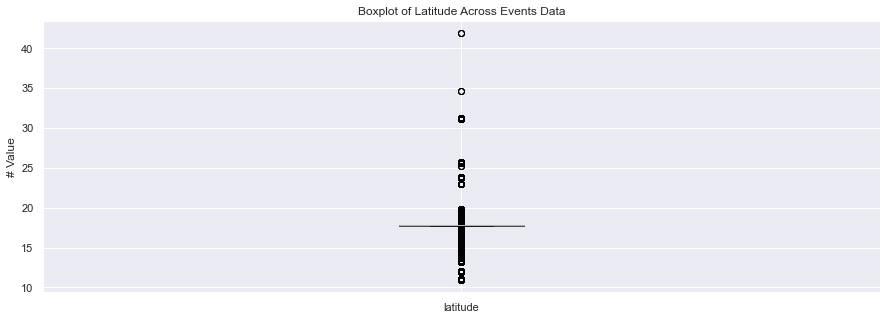

In [91]:
plt.figure(figsize=(15,5))
boxplot = df_events_data.boxplot(column='latitude')
plt.title('Boxplot of Latitude Across Events Data');
plt.ylabel("# Value")

In [92]:
df_events_data[df_events_data['latitude']>32]

event_id            device_id            timestamp  \
666553     226298  9078282559555458048  2016-05-05 15:21:49   
1630122   3020905  9078282559555458048  2016-05-05 11:57:30   
1756227   2949383  -601883305299256832  2016-05-06 18:29:57   
2110915   2997772  -601883305299256832  2016-05-04 14:45:21   
2207461   2976723  9078282559555458048  2016-05-06 17:00:08   
3162961    172407  -601883305299256832  2016-05-03 12:37:36   

                             longitude                       latitude  \
666553                            12.6                           41.9   
1630122                           12.6                           41.9   
1756227                           69.2                           34.6   
2110915                           69.2                           34.6   
2207461                           12.6                           41.9   
3162961                           69.2                           34.6   

                  city          state  
666553   Visakhapatnam  AndhraPradesh  
1630122  Visakhapatnam  AndhraPradesh  
1756227  Visakhapatnam  AndhraPradesh  
2110915  Visakhapatnam  AndhraPradesh  
2207461  Visakhapatnam  AndhraPradesh  
3162961  Visakhapatnam  AndhraPradesh

In [93]:
df_events_data[df_events_data['city']=='Visakhapatnam']['latitude'].mode()

0                             17.8
dtype: float64

In [94]:
mylist = df_events_data[df_events_data['latitude']>32]['event_id'].index.to_list()
for i in mylist:
    df_events_data.at[i,'latitude']=df_events_data[df_events_data['city']=='Visakhapatnam']['latitude'].mode()

Text(0, 0.5, '# Value')

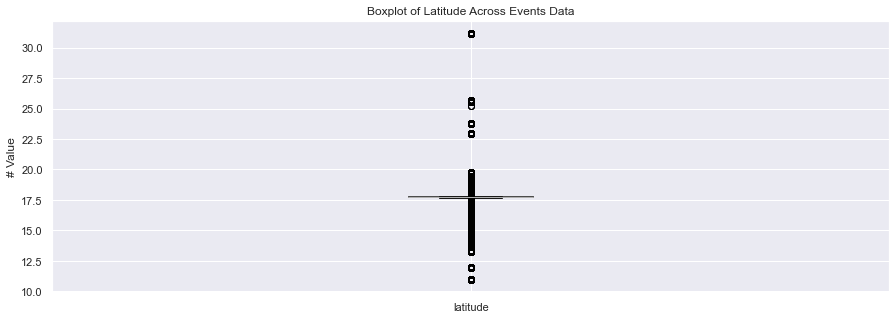

In [95]:
plt.figure(figsize=(15,5))
boxplot = df_events_data.boxplot(column='latitude')
plt.title('Boxplot of Latitude Across Events Data');
plt.ylabel("# Value")

Text(0, 0.5, '# Value')

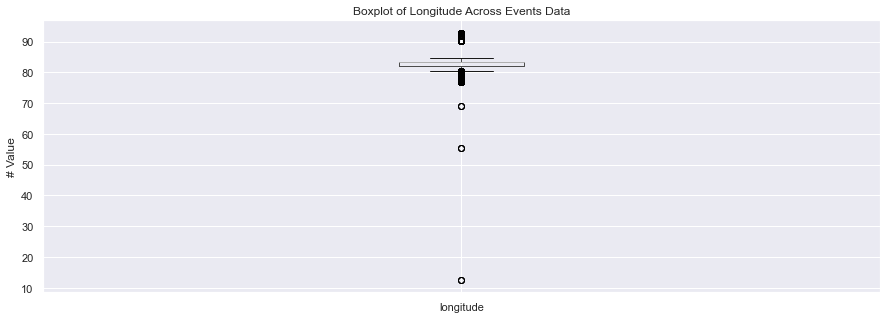

In [96]:
plt.figure(figsize=(15,5))
boxplot = df_events_data.boxplot(column='longitude')
plt.title('Boxplot of Longitude Across Events Data');
plt.ylabel("# Value")

In [97]:
df_events_data[df_events_data['longitude']<76]

event_id             device_id            timestamp  \
666553     226298   9078282559555458048  2016-05-05 15:21:49   
1630122   3020905   9078282559555458048  2016-05-05 11:57:30   
1756227   2949383   -601883305299256832  2016-05-06 18:29:57   
1997511    144746  -8647958547458784256  2016-05-05 13:19:15   
2110915   2997772   -601883305299256832  2016-05-04 14:45:21   
2207461   2976723   9078282559555458048  2016-05-06 17:00:08   
2635802   2862166  -8647958547458784256  2016-05-06 21:38:56   
2908542   2918560  -8647958547458784256  2016-05-06 20:41:13   
3162961    172407   -601883305299256832  2016-05-03 12:37:36   

                             longitude                       latitude  \
666553                            12.6                           17.8   
1630122                           12.6                           17.8   
1756227                           69.2                           17.8   
1997511                           55.3                           25.2   
2110915                           69.2                           17.8   
2207461                           12.6                           17.8   
2635802                           55.3                           25.2   
2908542                           55.3                           25.2   
3162961                           69.2                           17.8   

                  city          state  
666553   Visakhapatnam  AndhraPradesh  
1630122  Visakhapatnam  AndhraPradesh  
1756227  Visakhapatnam  AndhraPradesh  
1997511  Visakhapatnam  AndhraPradesh  
2110915  Visakhapatnam  AndhraPradesh  
2207461  Visakhapatnam  AndhraPradesh  
2635802  Visakhapatnam  AndhraPradesh  
2908542  Visakhapatnam  AndhraPradesh  
3162961  Visakhapatnam  AndhraPradesh

In [98]:
df_events_data[df_events_data['city']=='Visakhapatnam']['longitude'].mode()

0                             83.3
dtype: float64

In [99]:
mylist1 = df_events_data[(df_events_data['longitude']<76) \
                         & (df_events_data['city']=='Visakhapatnam')]['event_id'].index.to_list()
for i in mylist1:
    df_events_data.at[i,'longitude']=df_events_data[df_events_data['city']=='Visakhapatnam']['longitude'].mode()
    
#mylist2 = df_events_data[(df_events_data['longitude']<68) \
                        # & (df_events_data['city']=='Ilkal')]['event_id'].index.to_list()
#for i in mylist2:
    #df_events_data.at[i,'longitude']=df_events_data[df_events_data['city']=='Ilkal']['longitude'].mode()

Text(0, 0.5, '# Value')

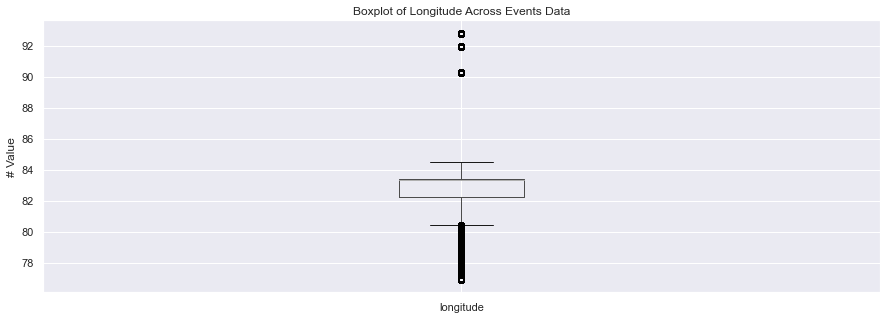

In [100]:
plt.figure(figsize=(15,5))
boxplot = df_events_data.boxplot(column='longitude')
plt.title('Boxplot of Longitude Across Events Data');
plt.ylabel("# Value")

Text(0.5, 0, 'Latitude')

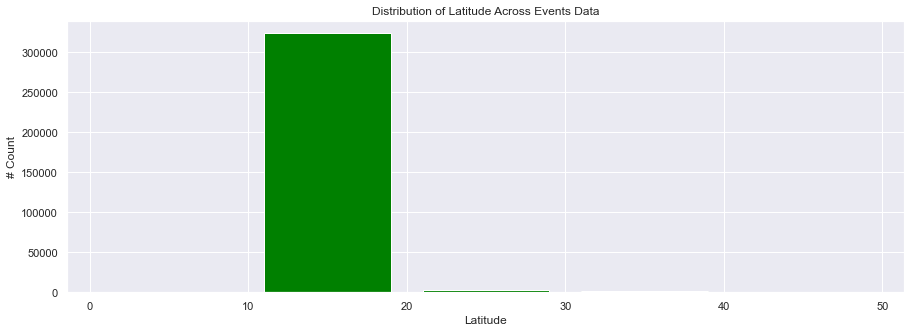

In [101]:
plt.figure(figsize=(15,5))
range = (0,50)
plt.hist(df_events_data['latitude'], 5, range, color = 'green', histtype = 'bar', rwidth = 0.8)
plt.title('Distribution of Latitude Across Events Data');
plt.ylabel("# Count")
plt.xlabel("Latitude")

Text(0.5, 0, 'Longitude')

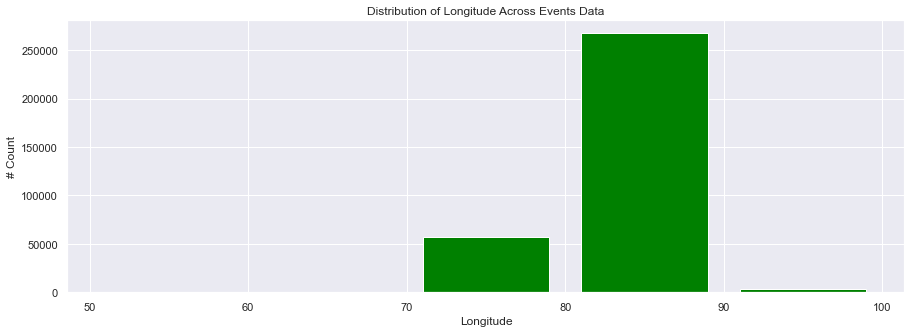

In [102]:
plt.figure(figsize=(15,5))
range = (50,100)
plt.hist(df_events_data['longitude'], 5, range, color = 'green', histtype = 'bar', rwidth = 0.8)
plt.title('Distribution of Longitude Across Events Data');
plt.ylabel("# Count")
plt.xlabel("Longitude")

<a id=section206></a>
### 2.3 Merging Datasets - Phone, Gender and Events

In [103]:
df_gender_age_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74645 entries, 0 to 74644
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   device_id  74645 non-null  int64 
 1   gender     74645 non-null  object
 2   age        74645 non-null  int64 
 3   group      74645 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [104]:
df_phone_brand_device_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87726 entries, 0 to 87725
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   device_id     87726 non-null  int64 
 1   phone_brand   87726 non-null  object
 2   device_model  87726 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [105]:
df_events_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327657 entries, 5 to 3252948
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   event_id   327657 non-null  int64  
 1   device_id  327657 non-null  Int64  
 2   timestamp  327657 non-null  object 
 3   longitude  327657 non-null  float64
 4   latitude   327657 non-null  float64
 5   city       327657 non-null  object 
 6   state      327657 non-null  object 
dtypes: Int64(1), float64(2), int64(1), object(3)
memory usage: 28.4+ MB


In [106]:
df_gender_age_train['device_id']=df_gender_age_train['device_id'].astype(float)

In [107]:
df_phone_brand_device_model['device_id']=df_phone_brand_device_model['device_id'].astype(float)

In [108]:
df_events_data['device_id']=df_events_data['device_id'].astype(float)

<ipython-input-108-1de06e6c4bb3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events_data['device_id']=df_events_data['device_id'].astype(float)


In [172]:
df_final = df_events_data.merge(df_phone_brand_device_model,on='device_id').merge(df_gender_age_train,on='device_id',indicator=True)

In [173]:
# importing sweetviz
import sweetviz as sv

In [174]:
#analyzing the dataset
final_data_report = sv.analyze(df_final)
#display the report
final_data_report.show_html('fianl_data_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report fianl_data_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [175]:
df_final.shape

(327657, 13)

In [176]:
missing_data(df_final)

Total                        Percent
event_id          0                            0.0
device_id         0                            0.0
timestamp         0                            0.0
longitude         0                            0.0
latitude          0                            0.0
city              0                            0.0
state             0                            0.0
phone_brand       0                            0.0
device_model      0                            0.0
gender            0                            0.0
age               0                            0.0
group             0                            0.0
_merge            0                            0.0

In [179]:
df_final.to_csv('raw_data.csv', index=False)
#phone_brand_device_model.to_csv('raw_data1.csv')
#gender_age_train.to_csv('raw_data2.csv')
#events_data.to_csv('raw_data3.csv')

In [112]:
df_events_data['timestamp']=pd.to_datetime(df_events_data['timestamp'])

<ipython-input-112-2978b1a6cd27>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events_data['timestamp']=pd.to_datetime(df_events_data['timestamp'])


In [113]:
df_final.columns

Index(['event_id', 'device_id', 'timestamp', 'longitude', 'latitude', 'city',
       'state', 'phone_brand', 'device_model', 'gender', 'age', 'group'],
      dtype='object')

In [114]:
CONTINUOUS_COLUMNS = ["age", "latitude", "longitude"]

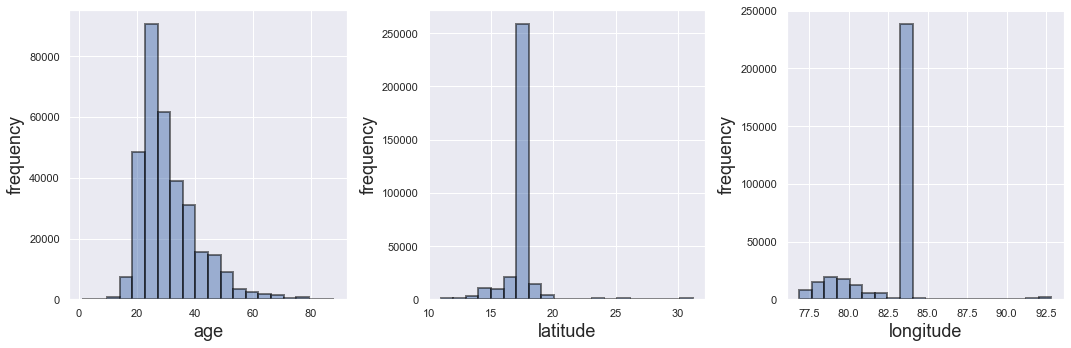

In [115]:
def plot_histgrams(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        X = data[col].dropna()
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.hist(X, bins=20, alpha=0.5, \
                 edgecolor="black", linewidth=2.0)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_histgrams(df_final[CONTINUOUS_COLUMNS])

In [116]:
CATEGORICAL_COLUMNS = ["group", "gender", "state"]

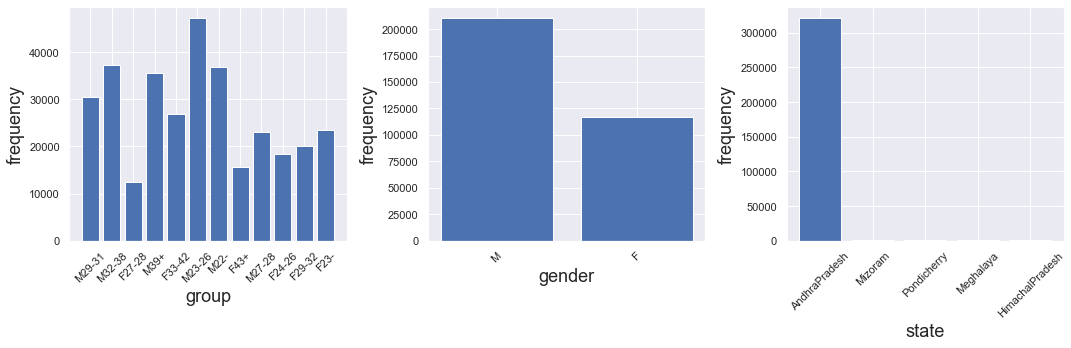

In [117]:


def plot_categoricals(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        cnt = Counter(data[col])
        keys = list(cnt.keys())
        vals = list(cnt.values())
        #range(len(keys))
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.bar(keys, vals, align="center")
        plt.xticks(keys, keys, rotation=45)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_categoricals(df_final[CATEGORICAL_COLUMNS])

In [118]:
df_final.groupby(['state', 'phone_brand']).device_model.value_counts().nlargest(10)

state          phone_brand  device_model 
AndhraPradesh  Xiaomi       Redmi note       15590
                            MI 2S            10455
               Samsung      Galaxy Note 3    10238
               Xiaomi       MI 3              9681
                            红米1S              7250
               Samsung      Galaxy Note 2     6236
                            Galaxy S4         5901
               Xiaomi       MI 4              5896
               Samsung      Galaxy S3         5420
               Xiaomi       红米Note2           5288
Name: device_model, dtype: int64

In [119]:
df_final.groupby(['phone_brand','device_model']).agg(lambda x:x.value_counts().index[0])

event_id                      device_id  \
phone_brand device_model                                            
 Aiyouni    U2              907341    1,250,569,025,258,516,736.0   
            U3              998102   -2,225,264,264,440,420,608.0   
 Candied    T3             2830272   -7,249,100,931,965,015,040.0   
 Coolby     H1              783362    5,260,702,995,951,480,832.0   
            H3             1741185   -8,194,554,351,819,241,472.0   
...                            ...                            ...   
vivo        Y927           2180672   -3,527,156,573,541,447,680.0   
            Y928            664835   -4,767,599,354,388,695,040.0   
奥克斯         V965T          1335339    5,489,607,796,787,403,776.0   
欧乐迪         Z1988           293888    2,199,613,157,955,485,184.0   
百加          V6              363804     -265,026,151,563,036,832.0   

                                    timestamp                      longitude  \
phone_brand device_model                                                       
 Aiyouni    U2            2016-05-07 17:48:57                           83.3   
            U3            2016-05-03 21:30:38                           79.9   
 Candied    T3            2016-05-06 18:22:33                           83.3   
 Coolby     H1            2016-05-03 03:07:22                           81.6   
            H3            2016-05-07 11:24:30                           83.3   
...                                       ...                            ...   
vivo        Y927          2016-05-05 15:13:53                           83.3   
            Y928          2016-05-07 14:11:34                           84.0   
奥克斯         V965T         2016-05-02 11:51:55                           81.5   
欧乐迪         Z1988         2016-05-03 12:10:33                           83.4   
百加          V6            2016-05-06 10:46:06                           82.6   

                                               latitude            city  \
phone_brand device_model                                                  
 Aiyouni    U2                                     17.7        Gajuwaka   
            U3                                     12.0     Pondicherry   
 Candied    T3                                     17.7   Visakhapatnam   
 Coolby     H1                                     16.9  Tadepallegudem   
            H3                                     17.8   Visakhapatnam   
...                                                 ...             ...   
vivo        Y927                                   17.8   Visakhapatnam   
            Y928                                   18.4      Srikakulam   
奥克斯         V965T                                  16.6      Bhimavaram   
欧乐迪         Z1988                                  17.8   Visakhapatnam   
百加          V6                                     17.4            Tuni   

                                  state gender  age   group  
phone_brand device_model                                     
 Aiyouni    U2            AndhraPradesh      F   26  F24-26  
            U3              Pondicherry      M   28  M27-28  
 Candied    T3            AndhraPradesh      M   44    M39+  
 Coolby     H1            AndhraPradesh      M   49    M39+  
            H3            AndhraPradesh      M   26  M23-26  
...                                 ...    ...  ...     ...  
vivo        Y927          AndhraPradesh      F   28  F27-28  
            Y928          AndhraPradesh      M   29  M29-31  
奥克斯         V965T         AndhraPradesh      F   43    F43+  
欧乐迪         Z1988         AndhraPradesh      M   19    M22-  
百加          V6            AndhraPradesh      F   27  F27-28  

[727 rows x 10 columns]

C:\Users\vbhak\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


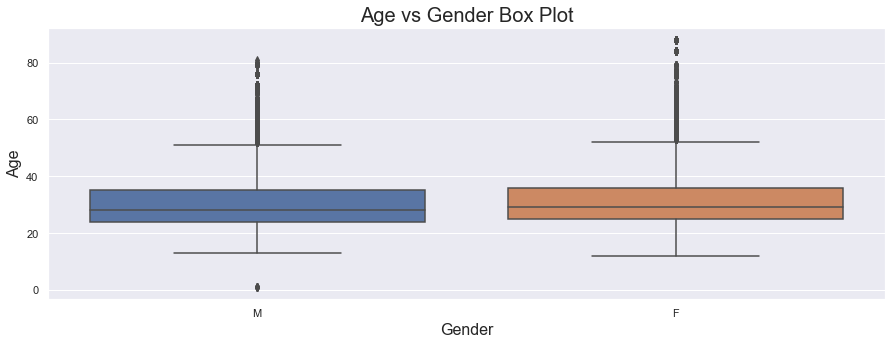

In [120]:
plt.figure(figsize=(15,5))
sns.boxplot(df_final['gender'], df_final['age'])
plt.title('Age vs Gender Box Plot', fontsize=20)      
plt.xlabel('Gender', fontsize=16)
plt.ylabel('Age', fontsize=16)
plt.show()

In [121]:
df_AndraPradesh = df_events_data[df_events_data.state =='AndhraPradesh']

In [122]:
#profile = pandas_profiling.ProfileReport(df_WestBengal)
#profile.to_file(output_file="westbengal_profiling.html")

In [123]:
df_Pondicherry = df_events_data[df_events_data.state =='Pondicherry']

In [124]:
#profile = pandas_profiling.ProfileReport(df_Karnataka)
#profile.to_file(output_file="karnataka_profiling.html")

In [125]:
df_Mizoram = df_events_data[df_events_data.state =='Mizoram']

In [126]:
#profile = pandas_profiling.ProfileReport(df_Gujarat)
#profile.to_file(output_file="gujarat_profiling.html")

In [127]:
df_Andaman_Nicobar = df_events_data[df_events_data.state =='Andaman and Nicobar Islands']

In [128]:
#profile = pandas_profiling.ProfileReport(df_Bihar)
#profile.to_file(output_file="bihar_profiling.html")

In [129]:
df_Meghalaya = df_events_data[df_events_data.state =='Meghalaya']

In [130]:
#profile = pandas_profiling.ProfileReport(df_Punjab)
#profile.to_file(output_file="punjab_profiling.html")

In [131]:
df_HimachalPradesh = df_events_data[df_events_data.state =='HimachalPradesh']

In [132]:
df_final.describe(include='all')

event_id                      device_id  \
count                       327,657.0                      327,657.0   
unique                            NaN                            NaN   
top                               NaN                            NaN   
freq                              NaN                            NaN   
mean                      1,625,845.8       94,542,180,551,240,608.0   
std                         940,398.8    5,343,419,007,504,409,600.0   
min                           5,985.0   -9,222,173,362,545,970,176.0   
25%                         811,242.0   -4,718,483,857,234,031,616.0   
50%                       1,627,221.0      -24,733,368,970,007,088.0   
75%                       2,439,822.0    4,865,606,571,395,668,992.0   
max                       3,252,943.0    9,220,807,070,557,263,872.0   

                  timestamp                      longitude  \
count                327657                      327,657.0   
unique               239787                            NaN   
top     2016-05-05 11:20:46                            NaN   
freq                     12                            NaN   
mean                    NaN                           82.4   
std                     NaN                            2.1   
min                     NaN                           76.9   
25%                     NaN                           82.2   
50%                     NaN                           83.3   
75%                     NaN                           83.4   
max                     NaN                           92.8   

                             latitude           city          state  \
count                       327,657.0         327657         327657   
unique                            NaN            112              5   
top                               NaN  Visakhapatnam  AndhraPradesh   
freq                              NaN         235772         321379   
mean                             17.6            NaN            NaN   
std                               1.5            NaN            NaN   
min                              10.9            NaN            NaN   
25%                              17.7            NaN            NaN   
50%                              17.8            NaN            NaN   
75%                              17.8            NaN            NaN   
max                              31.2            NaN            NaN   

       phone_brand device_model  gender                            age   group  
count       327657       327657  327657                      327,657.0  327657  
unique          69          719       2                            NaN      12  
top         Xiaomi   Redmi note       M                            NaN  M23-26  
freq         86778        15790  210571                            NaN   47306  
mean           NaN          NaN     NaN                           30.9     NaN  
std            NaN          NaN     NaN                            9.8     NaN  
min            NaN          NaN     NaN                            1.0     NaN  
25%            NaN          NaN     NaN                           24.0     NaN  
50%            NaN          NaN     NaN                           29.0     NaN  
75%            NaN          NaN     NaN                           35.0     NaN  
max            NaN          NaN     NaN                           88.0     NaN

In [133]:
df_final['device_id'].nunique()

5182

In [134]:
df_final.shape

(327657, 12)

In [135]:
df_final['timestamp']=pd.to_datetime(df_final['timestamp'])

In [136]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327657 entries, 0 to 327656
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_id      327657 non-null  int64         
 1   device_id     327657 non-null  float64       
 2   timestamp     327657 non-null  datetime64[ns]
 3   longitude     327657 non-null  float64       
 4   latitude      327657 non-null  float64       
 5   city          327657 non-null  object        
 6   state         327657 non-null  object        
 7   phone_brand   327657 non-null  object        
 8   device_model  327657 non-null  object        
 9   gender        327657 non-null  object        
 10  age           327657 non-null  int64         
 11  group         327657 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 40.6+ MB


In [137]:
df_final.describe()

event_id                      device_id  \
count                      327,657.0                      327,657.0   
mean                     1,625,845.8       94,542,180,551,240,608.0   
std                        940,398.8    5,343,419,007,504,409,600.0   
min                          5,985.0   -9,222,173,362,545,970,176.0   
25%                        811,242.0   -4,718,483,857,234,031,616.0   
50%                      1,627,221.0      -24,733,368,970,007,088.0   
75%                      2,439,822.0    4,865,606,571,395,668,992.0   
max                      3,252,943.0    9,220,807,070,557,263,872.0   

                           longitude                       latitude  \
count                      327,657.0                      327,657.0   
mean                            82.4                           17.6   
std                              2.1                            1.5   
min                             76.9                           10.9   
25%                             82.2                           17.7   
50%                             83.3                           17.8   
75%                             83.4                           17.8   
max                             92.8                           31.2   

                                 age  
count                      327,657.0  
mean                            30.9  
std                              9.8  
min                              1.0  
25%                             24.0  
50%                             29.0  
75%                             35.0  
max                             88.0

<a id=section3></a>
### 3. Anamoly Detection

In [138]:

# Make an empty map
map = folium.Map(location=[17.356359, 80.395484], zoom_start=5)
mc = MarkerCluster()
state_list = ['AndhraPradesh', 'Pondicherry', 'Mizoram', 'Andaman and Nicobar Islands', 'Meghalaya', 'HimachalPradesh']

for state in state_list:
    mapping_data = df_events_data[['latitude', 'longitude','city']][df_events_data['state']==state].drop_duplicates()
    latitude_list = []
    longitude = []
    citylist = []
    for city in mapping_data.city.unique().tolist():
        latitude_list.append(mapping_data.latitude[mapping_data['city']==city].mean())
        longitude.append(mapping_data.longitude[mapping_data['city']==city].mean())   
        citylist.append(city)
    
    df_data = pd.DataFrame(
    {'latitude' : latitude_list,
     'longitude' : longitude,
     'city' : citylist
    })
    
    locations = df_data[['latitude', 'longitude']]
    locationlist = locations.values.tolist()
    
    for index, item in enumerate(locationlist):
        mc.add_child(folium.Marker(location=item, popup=citylist[index]))
                             
map.add_child(mc)
map.save("state_wise_map_plot.html")
map

In [139]:
locations = df_events_data[['longitude','latitude']]
locations.reset_index(drop=True,inplace=True)
colordict = {0: 'lightblue', 1: 'lightgreen', 2: 'orange', 3: 'red'}


In [140]:
city_map = folium.Map(location=[20.5937,78.9629],zoom_start=5)

In [141]:
df = df_events_data[['latitude','longitude','city','state']]
df = df.drop_duplicates(keep='first',).reset_index()

In [142]:
for lat,long,city,state in zip(df['latitude'],df['longitude'],df['city'],df['state']):
    folium.CircleMarker(location=[lat,long],fill_opacity=0.7,fill=True,key_on =state,color='b', \
                        radius=2,weight=0).add_to(city_map)

In [143]:
city_map.save("city_wise_map_plot.html")
city_map

<a id=section4></a>
## 4. Plotting Distributions

In [144]:
user_data = df_final.drop(['event_id','timestamp'],axis=1)
user_data = user_data.drop_duplicates(keep='first').reset_index()
print(user_data.shape)
user_data.head(2)

(5188, 11)


index                      device_id                      longitude  \
0      0     -512,424,213,979,236,416.0                           83.4   
1     82   -8,879,643,774,076,165,120.0                           78.2   

                        latitude           city          state phone_brand  \
0                           17.8  Visakhapatnam  AndhraPradesh      Xiaomi   
1                           16.4       Wanparti  AndhraPradesh     Samsung   

  device_model gender  age   group  
0        MI 2A      M   31  M29-31  
1   Galaxy On7      M   34  M32-38

<a id=section400></a>
### 4.1 Distribution of Users(device_id) across States

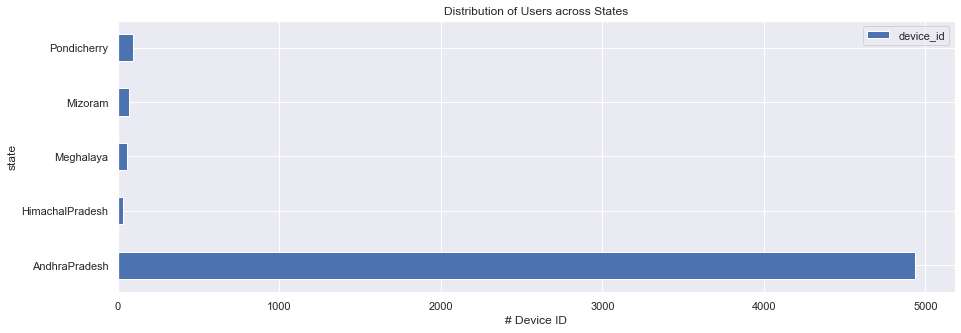

In [145]:
plt.figure(figsize=(15,5))
user_data.groupby('state').device_id.count().plot(kind='barh')
plt.title('Distribution of Users across States');
plt.xlabel("# Device ID")
plt.legend();

<a id=section401></a>
### 4.2 Distribution of Users across Phone Brands(10 Most used Phone Brands)

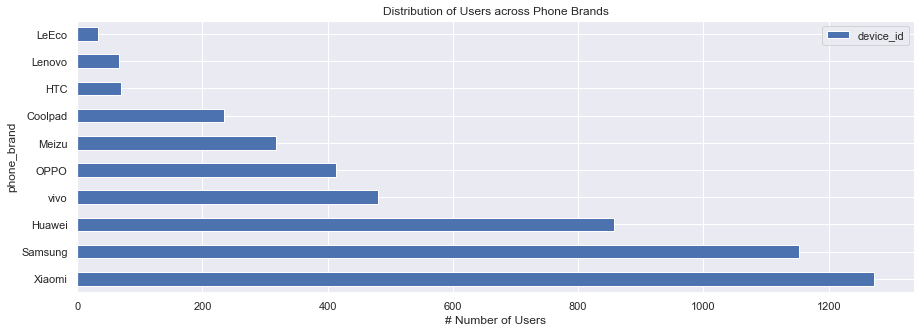

In [146]:
plt.figure(figsize=(15,5))
user_data.groupby('phone_brand').device_id.count().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Distribution of Users across Phone Brands');
plt.xlabel('# Number of Users');
plt.legend();

Text(0.5, 1.0, 'Phone Brand Distribution Across States')

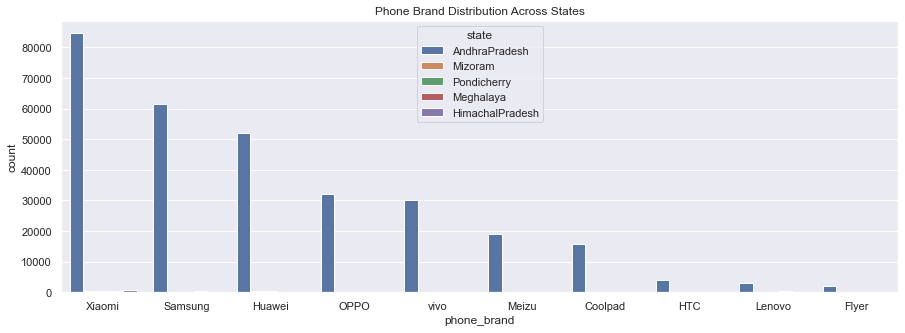

In [147]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='phone_brand', hue="state",order=df_final.phone_brand.value_counts().iloc[:10].index, data=df_final, ax=axis1)
plt.title("Phone Brand Distribution Across States")

Text(0.5, 1.0, 'Device Model Distribution Across States')

C:\Users\vbhak\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32418 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vbhak\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 31859 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vbhak\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 32418 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\vbhak\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 31859 missing from current font.
  font.set_text(s, 0, flags=flags)


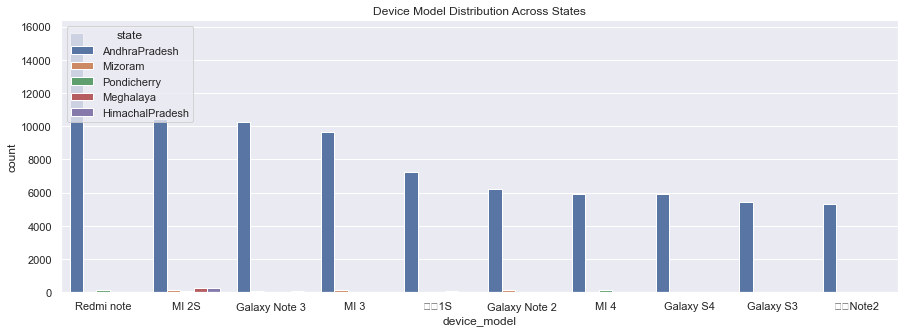

In [148]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='device_model', hue="state",order=df_final.device_model.value_counts().iloc[:10].index, data=df_final, ax=axis1)
plt.title("Device Model Distribution Across States")

<a id=section402></a>
### 4.3 Distribution of Users across Gender

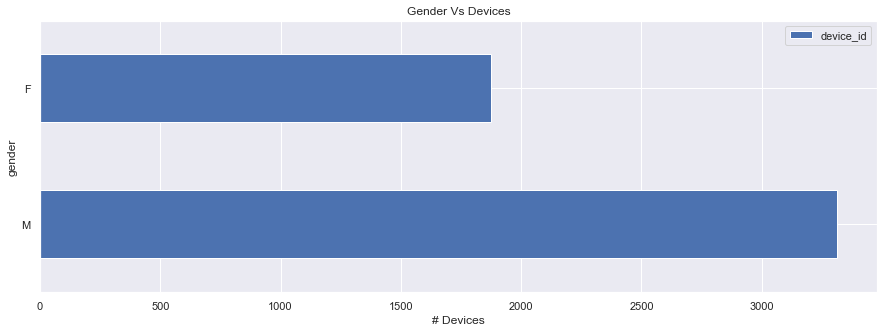

In [149]:
plt.figure(figsize=(15,5))
user_data.groupby('gender').device_id.count().sort_values(ascending=False).plot(kind='barh')
plt.title('Gender Vs Devices')
plt.xlabel('# Devices')
plt.legend()

Text(0.5, 1.0, 'Gender Distribution')

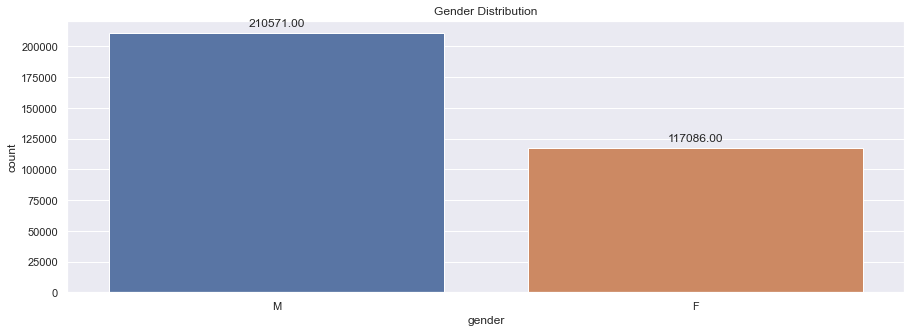

In [150]:
axis1 = plt.subplots(1,1,figsize=(15,5))
splot = sns.countplot(x='gender',data=df_final)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), \
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title("Gender Distribution")

M    210571
F    117086
Name: gender, dtype: int64


Text(0.5, 1.0, 'Gender Distribution - Pie Chart')

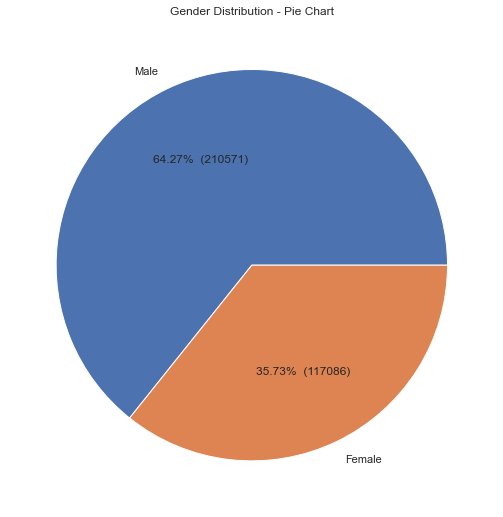

In [151]:
axis1 = plt.subplots(1,1,figsize=(15,9))
values=df_final['gender'].value_counts()
print(values)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
# Using matplotlib pie chart and label the pie chart
plt.pie(values,labels=['Male','Female'], autopct=make_autopct(values));
plt.title("Gender Distribution - Pie Chart")

Text(0.5, 1.0, 'Gender Vs Age Distribution')

<Figure size 1080x360 with 0 Axes>

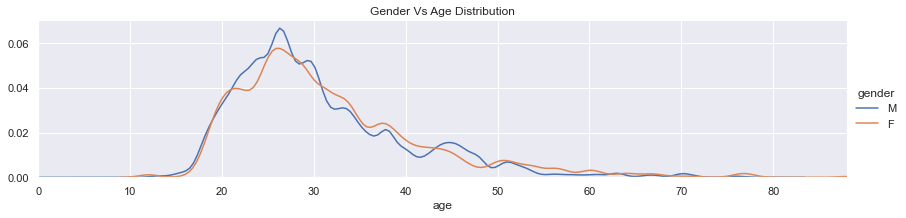

In [152]:
plt.figure(figsize=(15,5))
facet = sns.FacetGrid(df_final, hue="gender",aspect=4, hue_order=['M', 'F'])
facet.map(sns.kdeplot,'age')
facet.set(xlim=(0, df_final['age'].max()))
facet.add_legend()
plt.title("Gender Vs Age Distribution")

C:\Users\vbhak\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

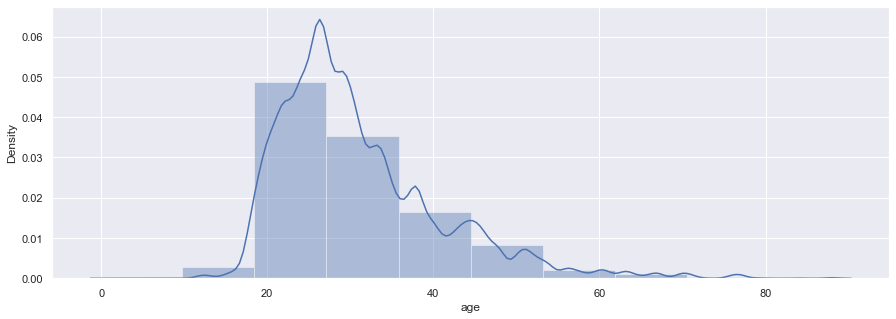

In [153]:
plt.figure(figsize=(15,5))
sns.distplot(df_final["age"],bins=10,kde=True)

Text(0.5, 1.0, 'Age distribution Across States')

<Figure size 1080x360 with 0 Axes>

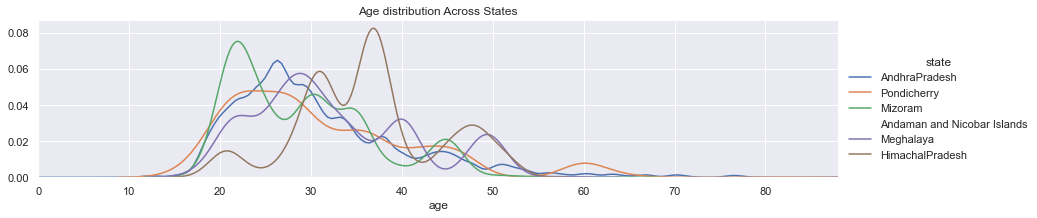

In [154]:
plt.figure(figsize=(15,5))
facet = sns.FacetGrid(df_final, hue="state",aspect=4, hue_order=['AndhraPradesh', 'Pondicherry', 'Mizoram', 'Andaman and Nicobar Islands', 'Meghalaya', 'HimachalPradesh'])
facet.map(sns.kdeplot,'age') 
facet.set(xlim=(0, df_final['age'].max()))
facet.add_legend()
plt.title("Age distribution Across States")

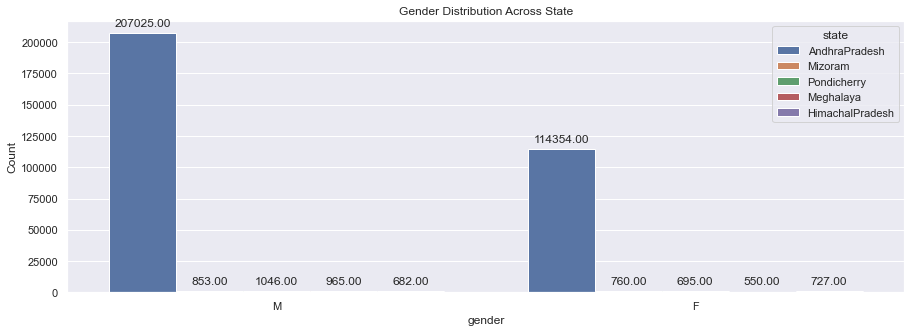

In [155]:
total = len(df_final['gender'])*1.
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
splot = sns.countplot(x='gender', hue="state", data=df_final, ax=axis1)
plt.title("Gender Distribution Across State")
plt.ylabel('Count')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


Text(0.5, 1.0, 'Age Vs Gender Distribution')

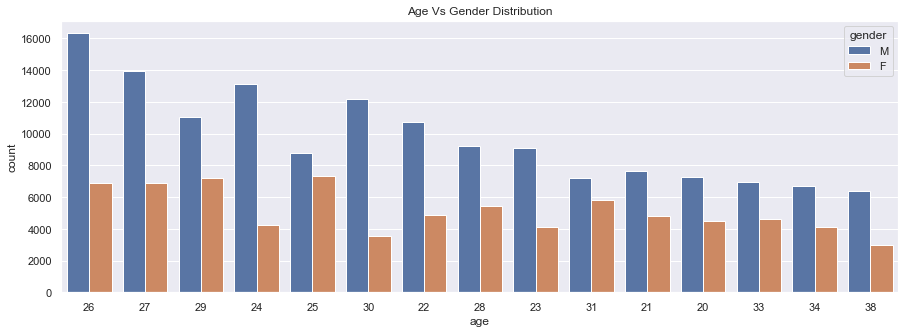

In [156]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='age', hue="gender", order=df_final.age.value_counts().iloc[:15].index, data=df_final, ax=axis1)
plt.title("Age Vs Gender Distribution")

Text(0.5, 1.0, 'Overall Gender Distribution Across States')

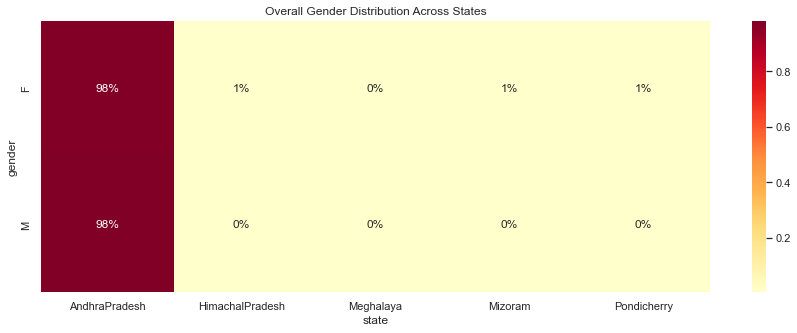

In [157]:
plt.figure(figsize=(15,5))
role_ed_xtab = pd.crosstab(df_final['gender'], df_final['state'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')
plt.title("Overall Gender Distribution Across States")

Text(0.5, 1.0, 'Age Group Distribution Across States')

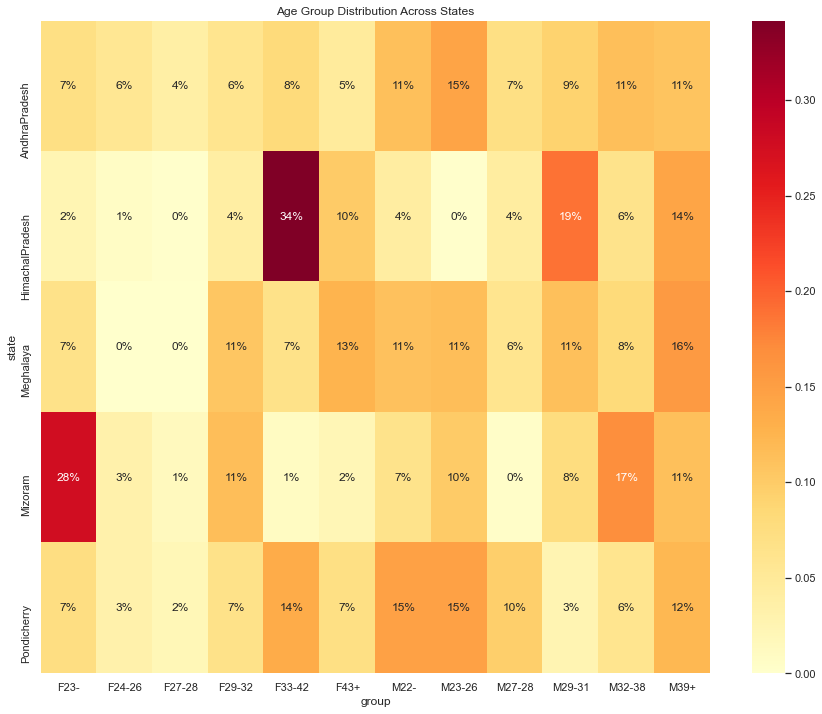

In [158]:
plt.figure(figsize=(15,12))
role_ed_xtab = pd.crosstab(df_final['state'], df_final['group'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')
plt.title("Age Group Distribution Across States")

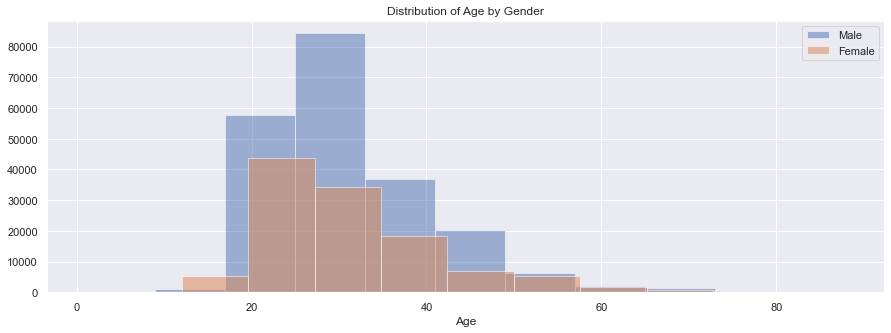

In [159]:
plt.figure(figsize=(15,5))
plt.hist('age', data=df_final[df_final['gender'] == 'M'], alpha=0.5, label='Male');
plt.hist('age', data=df_final[df_final['gender'] == 'F'], alpha=0.5, label='Female');
plt.title('Distribution of Age by Gender');
plt.xlabel('Age');
plt.legend();

<a id=section403></a>
### 4.4 Distribution of Users across Age Segments

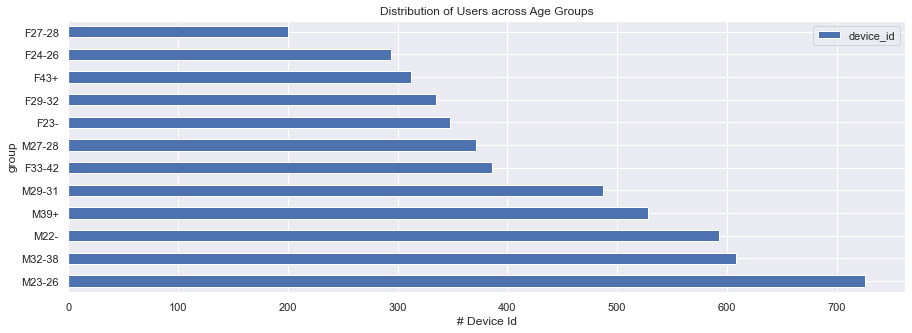

In [160]:
plt.figure(figsize=(15,5))
user_data.groupby('group').device_id.count().sort_values(ascending=False).plot(kind='barh')
plt.title('Distribution of Users across Age Groups');
plt.xlabel('# Device Id');
plt.legend();

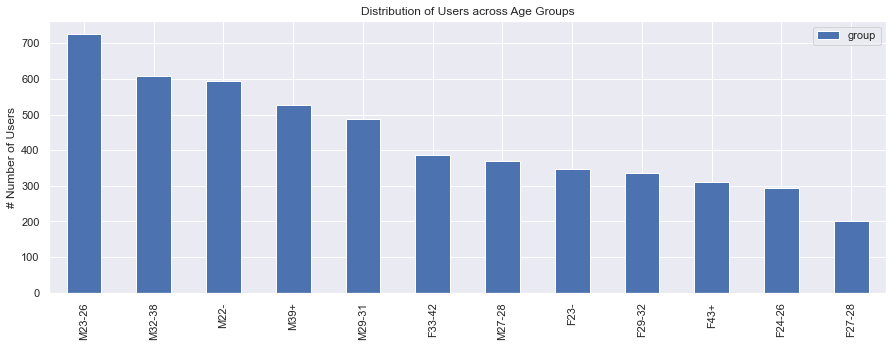

In [161]:
plt.figure(figsize=(15,5))
user_data['group'].value_counts().plot(kind='bar')
plt.title('Distribution of Users across Age Groups');
plt.ylabel('# Number of Users');
plt.legend();

In [162]:
age_group = [] 
for value in user_data['age']: 
    if value <=10: 
        age_group.append("Group-1") 
    elif value >10 and value <=20: 
        age_group.append("Group-2") 
    elif value>20 and value<=30:
        age_group.append("Group-3")
    elif value>30 and value<=40:
        age_group.append("Group-4")
    elif value>40 and value<=50:
        age_group.append("Group-5")
    elif value>50 and value<=60:
        age_group.append("Group-6")
    elif value>60 and value<=70:
        age_group.append("Group-7")
    elif value>70 and value<=80:
        age_group.append("Group-8")
    elif value>80 and value<=90:
        age_group.append("Group-9")
    else: 
        age_group.append("Group-10") 
        
user_data['age_group'] = age_group  

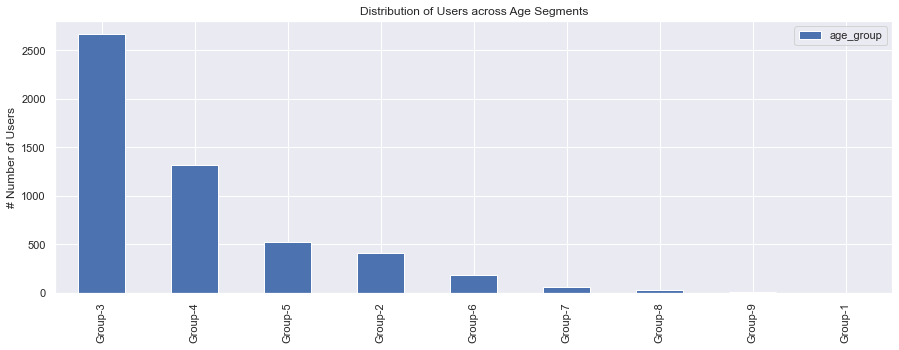

In [163]:
plt.figure(figsize=(15,5))
user_data['age_group'].value_counts().plot.bar()
plt.title('Distribution of Users across Age Segments');
plt.ylabel('# Number of Users');
plt.legend();

Text(0.5, 1.0, 'Age Group Distribution Across States')

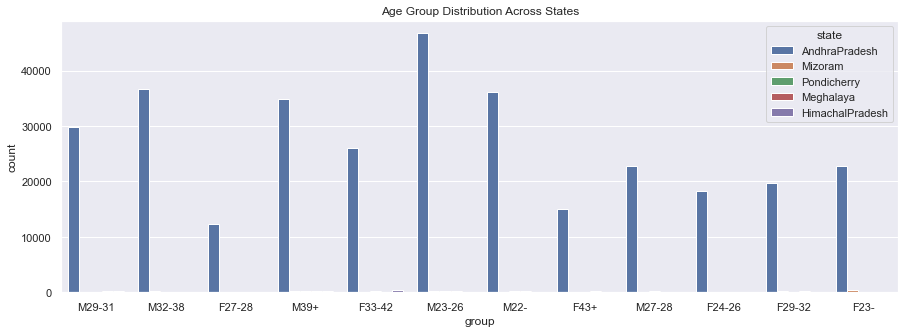

In [164]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='group', hue="state", data=df_final, ax=axis1)
plt.title("Age Group Distribution Across States")

In [165]:
df_AndhraPradesh = df_final[df_final.state=='AndhraPradesh']
df_Mizoram = df_final[df_final.state=='Mizoram']
df_Pondicherry = df_final[df_final.state=='Pondicherry']
df_Meghalaya = df_final[df_final.state=='Meghalaya']
df_HimachalPradesh = df_final[df_final.state=='HimachalPradesh']
df_Andaman_Nicobar = df_final[df_final.state=='Andaman and Nicobar islands']

<a id=section404></a>
### 4.5 Distribution of Phone Brands(10 Most used Phone Brand): Age Segment, State, Gender

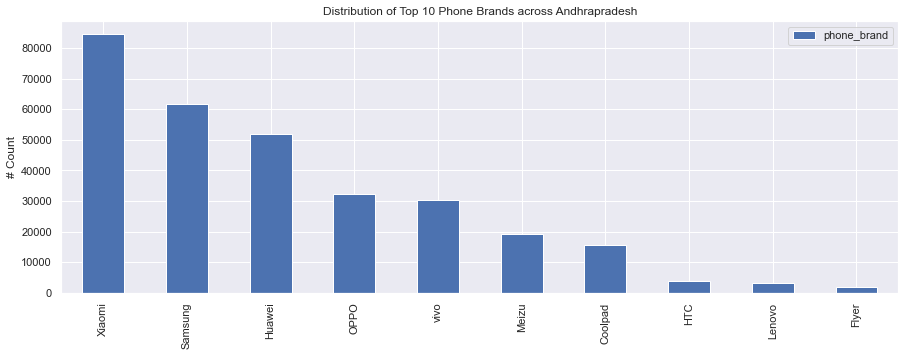

In [166]:
plt.figure(figsize=(15,5))
df_AndhraPradesh['phone_brand'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Phone Brands across Andhrapradesh');
plt.ylabel('# Count');
plt.legend();

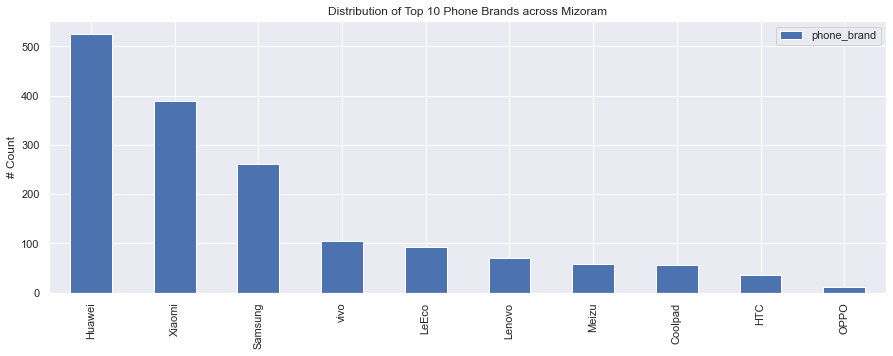

In [167]:
plt.figure(figsize=(15,5))
df_Mizoram['phone_brand'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Phone Brands across Mizoram');
plt.ylabel('# Count');
plt.legend();

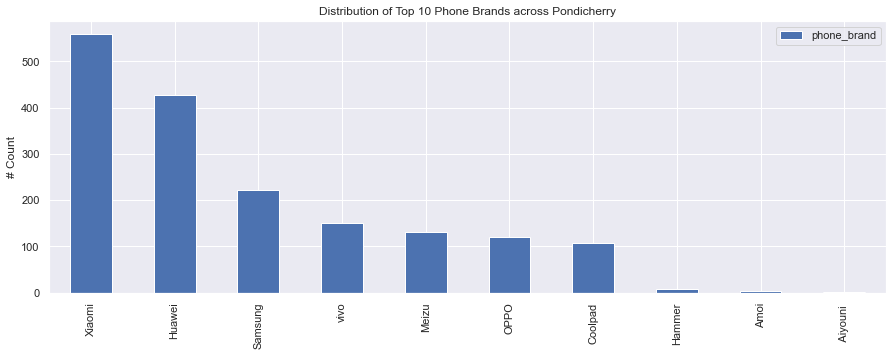

In [168]:
plt.figure(figsize=(15,5))
df_Pondicherry['phone_brand'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Phone Brands across Pondicherry');
plt.ylabel('# Count');
plt.legend();

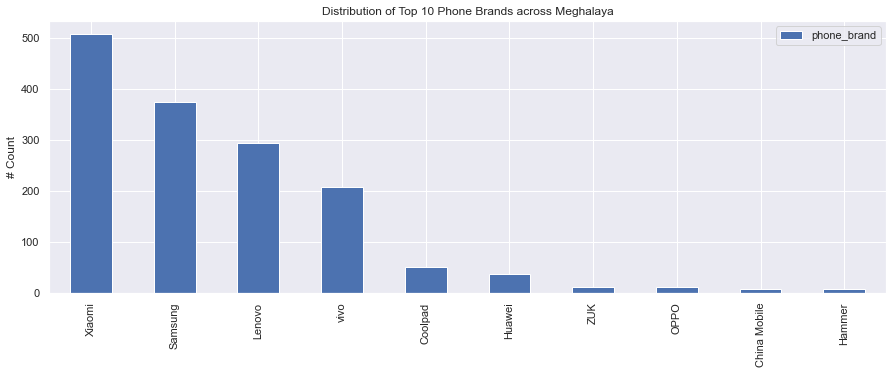

In [169]:
plt.figure(figsize=(15,5))
df_Meghalaya['phone_brand'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Phone Brands across Meghalaya');
plt.ylabel('# Count');
plt.legend();

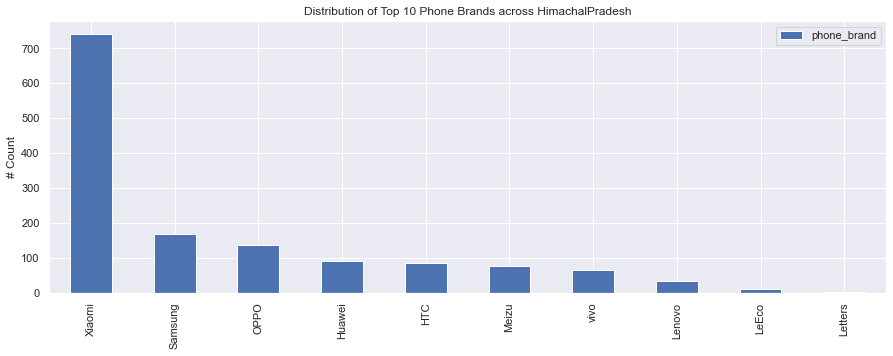

In [170]:
plt.figure(figsize=(15,5))
df_HimachalPradesh['phone_brand'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Phone Brands across HimachalPradesh');
plt.ylabel('# Count');
plt.legend();

In [171]:
plt.figure(figsize=(15,5)
df_Andaman_Nicobar['phone_brand'].value_counts().head(5).plot.bar()
plt.title('Distribution of Top 10 Phone Brands across Andaman and Nicobar islands');
plt.ylabel('# Count');
plt.legend();

SyntaxError: invalid syntax (<ipython-input-171-7cadb44902aa>, line 2)

In [ ]:
plt.figure(figsize=(15,5))
df_AndhraPradesh['device_model'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Devices across AP');
plt.ylabel('# Count of Devices');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Mizoram['device_model'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Devices across Mizoram');
plt.ylabel('# Count of Devices');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Meghalaya['device_model'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Devices across Meghalaya');
plt.ylabel('# Count of Devices');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Andaman_Nicobar['device_model'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Devices across Andaman and Nicobar');
plt.ylabel('# Count of Devices');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Pondicherry['device_model'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Devices across Pondicherry');
plt.ylabel('# Count of Devices');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Kerala['device_model'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Devices across Kerala');
plt.ylabel('# Count of Devices');
plt.legend();

In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='phone_brand', hue="state",order=df_final.phone_brand.value_counts().iloc[:10].index, data=df_final, ax=axis1)
plt.title("Top 10 Phone Brand Distribution Across States")

In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
splot = sns.countplot('group', hue='gender', data=df_WestBengal);
plt.title('Distribution of Phone Brand to Age Group, Colored by Gender');
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), \
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

<a id=section405></a>
### 4.6 Distribution of Gender for each State, Age Segment and Phone Brand(10 Most used Phone Brands)

In [ ]:
plt.figure(figsize=(15,5))
plt.hist('age', data=df_final[df_final['gender'] == 'M'], alpha=0.5, label='Male');
plt.hist('age', data=df_final[df_final['gender'] == 'F'], alpha=0.5, label='Female');
plt.title('Distribution of Age by Gender');
plt.xlabel('Age');
plt.legend();

In [ ]:
states = ['AndhraPradesh', 'Pondicherry', 'Mizoram', 'Andaman and Nicobar Islands', 'Meghalaya', 'HimachalPradesh']

for state in states:
    fig, axes = plt.subplots(figsize=(5,5))
    df_final[df_final['state']==state]['gender'].value_counts().head().plot.bar()
    plt.title(state)
    plt.ylabel('# Count')
fig.tight_layout()
fig.show()    

<a id=section406></a>
### 4.7 Distribution of Age Segments for each State, Gender and Phone Brand(10 Most used Phone Brands)

In [ ]:
df_final['state'].value_counts()

In [ ]:
plt.figure(figsize=(15,5))
df_final['state'].value_counts().plot.barh()

In [ ]:
plt.figure(figsize=(15,5))
df_final['city'].value_counts().head().plot.barh()

In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='phone_brand', hue="state",order=df_final.phone_brand.value_counts().iloc[:10].index, data=df_final, ax=axis1)
plt.title("Top 10 Phone Brand Distribution Across States")

In [ ]:
list_metro_cities = ['Calcutta', 'Bangalore', 'Ahmadabad', 'Surat']
for i in list_metro_cities:
    #print (i)
    #print (df_final[df_final['city']==i]['device_model'].value_counts().head(10))
    fig, axis1 = plt.subplots(1,1,figsize=(15,5))
    sns.countplot(x='phone_brand' ,order=df_final.phone_brand.value_counts().iloc[:10].index, data=df_final[df_final['city']==i], ax=axis1)
    plt.title("Top 10 Phone Brand Distribution Across " + i)
    

In [ ]:
metro_city_data = df_final[df_final.city.isin(list_metro_cities)]

In [ ]:
metro_city_data.groupby(['gender','city'])['city'].count()


In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
splot = sns.countplot(x='city', hue='gender', data=metro_city_data, ax=axis1)
plt.title("Metro City Distribution")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), \
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
facet = sns.FacetGrid(metro_city_data, hue="city",aspect=4, hue_order=['Calcutta', 'Bangalore', 'Ahmadabad', 'Surat'])
facet.map(sns.kdeplot,'age') 
facet.set(xlim=(0, metro_city_data['age'].max()))
facet.add_legend()
plt.title("Age distribution Across Metro city Data")

In [ ]:
non_metro_city_data = df_final[~df_final['city'].isin(list_metro_cities)]

In [ ]:
non_metro_city_data['city'].value_counts().head(7)

In [ ]:
facet = sns.FacetGrid(non_metro_city_data, hue="city",aspect=4, hue_order=['Bagaha','Dinapur','Bankura','Ponnani','Channapatna'])
facet.map(sns.kdeplot,'age') 
facet.set(xlim=(0, non_metro_city_data['age'].max()))
facet.add_legend()
plt.title("Age distribution Across Non Metro city Data")

In [ ]:
df_final.columns

In [ ]:
x = df_final['phone_brand'].value_counts().head(10)
x

In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
x.plot(kind='barh')
plt.show()

In [ ]:
brand_count  = df_final['phone_brand'].value_counts()
brand_count = brand_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(brand_count.index, brand_count.values, alpha=0.8)
plt.title('Phone Brands - Top 10')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Phone Brands', fontsize=12)
plt.show()

In [ ]:
df_final['group'].value_counts().head(10)

In [ ]:
group_count  = df_final['group'].value_counts()
group_count = group_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(group_count.index, group_count.values, alpha=0.8)
plt.title('Distribution Across Age Groups')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Age Groups', fontsize=12)
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.hist('age', data=df_final[df_final['gender'] == 'M'], alpha=0.5, label='Male');
plt.hist('age', data=df_final[df_final['gender'] == 'F'], alpha=0.5, label='Female');
plt.title('Distribution of Age by Gender');
plt.xlabel('Age Group');
plt.legend();

<a id=section407></a>
### 4.8 Hourly distribution of Phone Calls

In [ ]:
df_final.sample(10)

In [ ]:
df_final['timestamp'] = pd.to_datetime(df_final['timestamp'])

In [ ]:
df_final['date'] = pd.to_datetime(df_final['timestamp']).dt.date
df_final['time'] = pd.to_datetime(df_final['timestamp']).dt.time
df_final['date'] = pd.to_datetime(df_final['date'])
df_final['day'] = pd.to_datetime(df_final['timestamp']).dt.weekday_name
df_final['month']= pd.to_datetime(df_final['timestamp']).dt.month

In [ ]:
def finding_time_range(val):
    if(val >= time(8,0) and val < time(12,0)):
        return '08 to 12'
    elif(val >= time(12,0) and val < time(16,0)):
        return '12 to 16'
    elif(val >= time(16,0) and val < time(20,0)):
        return '16 to 20'
    elif(val >= time(20,0) and val < time(23,59)):
        return '20 to 00'
    elif(val >= time(0,0) and val < time(4,0)):
        return '00 to 04'
    elif(val >= time(4,0) and val < time(8,0)):
        return '04 to 08'


In [ ]:
df_final['timestamp'].sample(10)

In [ ]:
df_final.head(3)

In [ ]:
df_final['time_range'] = df_final['timestamp'].dt.hour

In [ ]:
plt.figure(figsize=(15,5))
g = sns.catplot(x="group", y='time_range', kind="violin", data=df_final)
g.set_xticklabels(rotation=45)

<a id=section408></a>
### 4.9 Users on the Map using any suitable package

In [ ]:
map2 = folium.Map(location=[22.356359, 79.395484], zoom_start=5)
mc2 = MarkerCluster()
state_list = ['AndhraPradesh', 'Pondicherry', 'Mizoram', 'Andaman and Nicobar Islands', 'Meghalaya', 'HimachalPradesh']

for state in state_list:
    mapping_data = df_events_data[['latitude', 'longitude','city']][df_events_data['state']==state].drop_duplicates()
    citylist = mapping_data['city'].tolist()
        
    locations = mapping_data[['latitude', 'longitude']]
    locationlist = locations.values.tolist()
    
    for index, item in enumerate(locationlist):
        mc2.add_child(folium.Marker(location=item, popup=citylist[index]))
                             
map2.add_child(mc2)
map2.save("state_wise_map_plot2.html")
map2

## Hourly distribution of phonecalls by age group for Male

In [ ]:
plt.figure(figsize=(15,5))
sns.catplot(x="group", y='time_range', kind="violin", data=df_final[df_final['gender']=='M'])

## Hourly distribution of phonecalls by age group for Female

In [ ]:
plt.figure(figsize=(15,5))
sns.catplot(x="group", y='time_range', kind="violin", data=df_final[df_final['gender']=='F'])

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(["age", "latitude", "longitude"], axes):
    sns.boxplot(data=df_final, x='month', y=name, ax=ax)
    ax.set_ylabel('# Events')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_final, x='day', y='event_id');

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_final, x='day', y='age');
plt.title("Age Distribution")

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(data=df_final, x='age',hue='day', order=df_final.age.value_counts().iloc[:10].index )
plt.ylabel('# Event Count')

## Statewise distribution of calls

In [ ]:
plt.figure(figsize=(15,5))
sns.catplot(x="state", y='time_range', kind="violin", data=df_final)

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='AndhraPradesh']['city'].value_counts().head().plot.bar()

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']== 'Pondicherry']['phone_brand'].value_counts().head().plot.bar()

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='WestBengal']['city'].value_counts().head().plot.bar()

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='Bihar']['city'].value_counts().head().plot.bar()

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='Gujarat']['city'].value_counts().head().plot.bar()

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='WestBengal']['city'].value_counts().head().plot.bar()

In [ ]:
city = ['Calcutta','Bankura','Krishnanagar','Gangarampur','Binnaguri','Bangalore','Channapatna','Ramanagaram','Ullal','Karwar','Dinapur','Madhipura','Purnia','Masaurhi','Bihar','Jetpur','Veraval','Unjha','Surat','Gondal','Ponnani','Malappuram','Kollam','Thiruvananthapuram','Tiruvalla','Patiala','Bathinda','Kapurthala','KotKapura','Sunam']
for i in city:
    #print (i)
    #print (df_final[df_final['city']==i]['device_model'].value_counts().head(10))
    fig, axis1 = plt.subplots(1,1,figsize=(15,5))
    sns.countplot(x='device_model' ,order=df_final.device_model.value_counts().iloc[:10].index, data=df_final[df_final['city']==i], ax=axis1)
    plt.title("Top 10 Device Model Distribution Across " + i)
    

In [ ]:
city = ['Calcutta','Bankura','Krishnanagar','Gangarampur','Binnaguri','Bangalore','Channapatna','Ramanagaram','Ullal','Karwar','Dinapur','Madhipura','Purnia','Masaurhi','Bihar','Jetpur','Veraval','Unjha','Surat','Gondal','Ponnani','Malappuram','Kollam','Thiruvananthapuram','Tiruvalla','Patiala','Bathinda','Kapurthala','KotKapura','Sunam']
for i in city:
    fig, axis1 = plt.subplots(1,1,figsize=(15,5))
    sns.countplot(x='phone_brand' ,order=df_final.phone_brand.value_counts().iloc[:10].index, data=df_final[df_final['city']==i], ax=axis1)
    plt.title("Top 10 Phone Brand Distribution Across " + i)
    #print (i)
    #print (df_final[df_final['city']==i]['phone_brand'].value_counts().head(10))

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='Punjab']['city'].value_counts().head().plot.bar()

In [ ]:
df_final[df_final['state']=='Bihar']['city'].value_counts().head()

In [ ]:
df_final['group'].unique()

### Popular phone brands among all age groups

In [ ]:
for i in df_final['group'].unique():
    #print ('-----------',i,'-----------')
    #print (df_final[df_final['group']==i]['phone_brand'].value_counts().head(10))
    fig, axis1 = plt.subplots(1,1,figsize=(15,5))
    sns.countplot(x='phone_brand' ,order=df_final.phone_brand.value_counts().iloc[:10].index, data=df_final[df_final['group']==i], ax=axis1)
    plt.title("Top 10 Phone Brand Distribution Across " + i)

### Popular device among all age group

In [ ]:
for i in df_final['group'].unique():
    #print ('-----------',i,'-----------')
    #print (df_final[df_final['group']==i]['device_model'].value_counts().head(10))
    fig, axis1 = plt.subplots(1,1,figsize=(15,5))
    sns.countplot(x='device_model' ,order=df_final.device_model.value_counts().iloc[:10].index, data=df_final[df_final['group']==i], ax=axis1)
    plt.title("Top 10 Device Model Distribution Across " + i)
    

In [ ]:
states_list = df_events_data['city'].groupby(df_events_data['state']).count()
states_list

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'],margins=True).sort_values('All',ascending=False)

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'][df_events_data['state'] == 'Karnataka'],margins=True)\
.sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'][df_events_data['state'] == 'WestBengal'],margins=True)\
.sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'][df_events_data['state'] == 'Gujarat'],margins=True)\
.sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'][df_events_data['state'] == 'Bihar'],margins=True)\
.sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'][df_events_data['state'] == 'Punjab'],margins=True)\
.sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'][df_events_data['state'] == 'Kerala'],margins=True)\
.sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_gender_age_train['gender'],df_gender_age_train['group'])

In [ ]:
pd.crosstab(df_gender_age_train['age'],df_gender_age_train['gender'],margins=True).sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_phone_brand_device_model['device_model'],df_phone_brand_device_model['phone_brand'],margins=True).sort_values('All',ascending=False).head(10)

In [ ]:
df_phone_brand_device_model['device_model'].groupby(df_phone_brand_device_model['phone_brand']).count().sort_values(ascending=False).head(10)

In [ ]:
df_phone_brand_device_model['phone_brand'].groupby(df_phone_brand_device_model['device_model']).count().sort_values(ascending=False).head(10)

<a id=section5></a>
## 5. Conclusion

**Brief summary of we discovered based on results**

- Insaid Telecom needs to perform few promotional activities for being strong competitor in the market:
        - Special Plan for different age band
        - Special Plan along with tie-up with top running Mobile Brand in the specific market
        - Re-visit their existing plan for Tier-1 city and rest small city
        
- Insaid Telecom has strong market place with 50 millions active devices on daily basis. Insaid telecom has High potential to engage more customers by giving promotions.

<a id=section6></a>
## 6. Core Team


## THANK YOU !